#1 Importing Libraries And Webscraping


##**1.1 Importing the necessary libraries on google colab**

---
The libraries that we have used is the openai,requests, pandas,numpy, beautifulsoup4 and yfinance libraries.
The first step would be to import or install these libraries to be able to use  them in the project later.



In [ ]:
### installing openai and importing openai
!pip install -q openai
import openai
from openai import OpenAI
#regex
import re
import pandas as pd
import numpy as np
import math
!pip install beautifulsoup4
import requests ### using requests to make connections to apis
from bs4 import BeautifulSoup ###
!pip install tiktoken
import tiktoken
!pip install yfinance --upgrade --no-cache-dir
import yfinance as yf
import requests

!pip install torch
!pip install torch-geometric
import torch
import torch.nn.functional as F
from torch_geometric.data import Data,DataLoader
from torch_geometric.nn import GCNConv,GATConv
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split,KFold
from torch.utils.data import random_split
import itertools


##**<h1>1.2 Webscraping For IPOs</h1>**



###**<h2>1.2.1 IPO Data From Stockanalysis.com/ipos</h2>**
----------------------------------------------------------
The steps below show webscraping from the stockanalysis website with the use of beautiful soup and since the website itself separates the ipos based on years, we are able to find the ipos on years with the method below. We then store it as an np array and finally convert it to a dataframe.


In [ ]:
base_url = "https://stockanalysis.com/ipos/{}/"
response = requests.get(base_url)
soup = BeautifulSoup(response.text,'html')

start_year = 2020
end_year = 2024
stock_list = []


for year in range(start_year, end_year+1):
  url = base_url.format(year)
  print(f"Fetching data from: {url}")
  response = requests.get(url)
  if response.status_code == 200:
    soup = BeautifulSoup(response.text,'html.parser')
    tbody = soup.find('tbody')
    if tbody:
      rows = tbody.find_all('tr')
      for row in rows:
        cells = row.find_all('td')
        data = [cell.text.strip() for cell in cells]
        if data:
          stock_list.append(data)
    else:
      print(f"No tbody found for year:{year}")
  else:
    print(f"Failed to fetch response from:{url}")


Stocks = np.array(stock_list,dtype=str)

df = pd.DataFrame(Stocks,columns=['Date','Ticker','Company Name',"IPO Price","Current Price","Price Change"])

print(df,Stocks)


Fetching data from: https://stockanalysis.com/ipos/2020/
Fetching data from: https://stockanalysis.com/ipos/2021/
Fetching data from: https://stockanalysis.com/ipos/2022/
Fetching data from: https://stockanalysis.com/ipos/2023/
Fetching data from: https://stockanalysis.com/ipos/2024/
              Date Ticker                                    Company Name  \
0     Dec 29, 2020    MRM            MEDIROM Healthcare Technologies Inc.   
1     Dec 24, 2020   VTAQ                   Ventoux CCM Acquisition Corp.   
2     Dec 23, 2020   HCAR     Healthcare Services Acquisition Corporation   
3     Dec 23, 2020   CFIV                         CF Acquisition Corp. IV   
4     Dec 23, 2020    VII                         7GC & Co. Holdings Inc.   
...            ...    ...                                             ...   
1966  Jan 18, 2024   PSBD                  Palmer Square Capital BDC Inc.   
1967  Jan 18, 2024   CCTG  CCSC Technology International Holdings Limited   
1968  Jan 12, 2024   S

###**<h2>1.2.2 Webscraping For IPOs using Yahoo Finance</h2>**

----------------------------------------------------------
The steps below are data retrieved from Yahoo Finance API for the Sector/Industry of the Companies.

1) initalise two empty lists to and gather the company info from the yahoo api and return the sector and industry and push them into the list of sectorRow and IndustryRow. We also keep an NP Array of the data frame objects for easier processing later on if we fail to transform the dataframe or other errors occur.

In [ ]:
SectorRow = []
IndustryRow = []

for i in df['Ticker']:
  ticker=i
  print(ticker)
  company = yf.Ticker(ticker)
  company_info = company.info
  sector = company_info.get("sector","Sector not found")
  industry = company_info.get("industry","Industry not found")
  SectorRow.append(sector)
  IndustryRow.append(industry)
print(SectorRow,IndustryRow)

In [ ]:
df.insert(loc=len(df.columns), column='Sector', value=SectorRow)
df.insert(loc=len(df.columns),column="Industry",value=IndustryRow)
print(df)


              Date Ticker                                    Company Name  \
0     Dec 29, 2020    MRM            MEDIROM Healthcare Technologies Inc.   
1     Dec 24, 2020   VTAQ                   Ventoux CCM Acquisition Corp.   
2     Dec 23, 2020   HCAR     Healthcare Services Acquisition Corporation   
3     Dec 23, 2020   CFIV                         CF Acquisition Corp. IV   
4     Dec 23, 2020    VII                         7GC & Co. Holdings Inc.   
...            ...    ...                                             ...   
1966  Jan 18, 2024   PSBD                  Palmer Square Capital BDC Inc.   
1967  Jan 18, 2024   CCTG  CCSC Technology International Holdings Limited   
1968  Jan 12, 2024   SYNX                                  Silynxcom Ltd.   
1969  Jan 11, 2024   SDHC                       Smith Douglas Homes Corp.   
1970   Jan 9, 2024   ROMA                      Roma Green Finance Limited   

     IPO Price Current Price Price Change             Sector  \
0       $15

In [ ]:
SectorRowNPArray = np.array(SectorRow,dtype=object).reshape(-1,1)
IndustryRowNPArray = np.array(IndustryRow,dtype=object).reshape(-1,1)
Stocks= np.hstack((Stocks,SectorRowNPArray))
Stocks = np.hstack((Stocks,IndustryRowNPArray))
print(Stocks[0])

['Dec 29, 2020' 'MRM' 'MEDIROM Healthcare Technologies Inc.' '$15.00'
 '$2.74' '-81.56%' 'Consumer Cyclical' 'Personal Services']


###****<h2>1.2.3 Webscraping For IPOs using NASDAQ API</h2>****

----------------------------------------------------------
From the codes below, it shows an extraction of the NASDAQ API to ensure that the data we have retrieved is true and also double check that the IPO_Price is true as Nasdaq is the stock exchange which listed the stock and is trustable. After which, we then use the Yahoo Finance API to find out the stocks' total asset, equities and earnings/losses.

In [ ]:

url = 'https://api.nasdaq.com/api/ipo/calendar'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:109.0) Gecko/20100101 Firefox/113.0'}
start_date = '2020-1-1'
end_date = '2023-5-31'
periods = pd.period_range(start_date, end_date, freq='M')
dfs = []
for period in periods:
    data = requests.get(url, headers=headers, params={'date': period}).json()
    df2 = pd.json_normalize(data['data']['priced'], 'rows')
    dfs.append(df2)
df2 = pd.concat(dfs, ignore_index=True)

In [ ]:
print(df2)

mrm_row = df2[df2['proposedTickerSymbol'] == 'MRM']
mrm_row_price = mrm_row['proposedSharePrice']
VTAQ_row = df2[df2['proposedTickerSymbol']=="VTAQ"]

print(VTAQ_row)
print(mrm_row)
print(mrm_row.empty)
print(VTAQ_row.empty)
print(mrm_row_price.values[0])
print(df.loc[df['Ticker'] == 'BLUW'])
df.loc[30,"Ticker"]="BLUW"


              dealID proposedTickerSymbol  \
0      1099162-91392                 ARQT   
1      1101484-91092                 REYN   
2       748340-91387                 ONEM   
3      1099989-90949                 ANPC   
4      1019150-91385                 BDTX   
...              ...                  ...   
1772  1210259-102635                  SGE   
1773  1239799-104989                ALCYU   
1774  1254469-106197                 SLRN   
1775  1243360-105271                 KVUE   
1776  1190851-101486                GODNU   

                                 companyName      proposedExchange  \
0              Arcutis Biotherapeutics, Inc.  NASDAQ Global Select   
1            Reynolds Consumer Products Inc.  NASDAQ Global Select   
2                       1life Healthcare Inc  NASDAQ Global Select   
3                           Fresh2 Group Ltd         NASDAQ Global   
4           Black Diamond Therapeutics, Inc.  NASDAQ Global Select   
...                                    

In [ ]:
df['sharesOffered'] = "0"
for ticker in df['Ticker']:
  ticker_row = df2[df2['proposedTickerSymbol'] == ticker]
  if not ticker_row.empty:
    ticker_row_price = ticker_row['proposedSharePrice']
    ticker_sharesOffered = ticker_row['sharesOffered']
    df.loc[df['Ticker'] == ticker, 'IPO Price'] = ticker_row_price.values[0]
    df.loc[df['Ticker'] == ticker,'sharesOffered'] = ticker_sharesOffered.values[0]

In [ ]:
df['TotalRevenue']= 0

for i in df['Ticker']:
  ticker=i
  last_position = -1
  company = yf.Ticker(ticker)
  Financials = company.financials
  if Financials.empty:
    print(f"No financial data found for {ticker}")
    continue
  if 'Total Revenue' in Financials.index:
    while math.isnan(Financials.loc["Total Revenue"][last_position]):
      last_position -= 1
    total_revenue_row = Financials.loc["Total Revenue"].iloc[last_position]
    df.loc[df['Ticker'] == ticker, 'TotalRevenue'] = '{:,.0f}'.format(total_revenue_row)
  else:
    print(f"'Total Revenue' not found for {ticker}")



In [ ]:
df['TotalAssets']= 0

for i in df['Ticker']:
  ticker=i
  last_position = -1
  company = yf.Ticker(ticker)
  Financials = company.balancesheet
  if Financials.empty:
    print(f"No financial data found for {ticker}")
    continue
  if 'Cash And Cash Equivalents' in Financials.index:
    while math.isnan(Financials.loc["Cash And Cash Equivalents"][last_position]):
      last_position -= 1
    total_assets_row = Financials.loc["Cash And Cash Equivalents"].iloc[last_position]
    df.loc[df['Ticker'] == ticker, 'TotalAssets'] = '{:,.0f}'.format(total_assets_row)
  else:
    print(f"'Total Revenue' not found for {ticker}")

In [ ]:
print(df)

#### saving the dataframe as a csv file
df.to_csv('dataset.csv',
    index=False,
    sep=',',
    header=True,
    na_rep='NA')

              Date Ticker                                    Company Name  \
0     Dec 29, 2020    MRM            MEDIROM Healthcare Technologies Inc.   
1     Dec 24, 2020   VTAQ                   Ventoux CCM Acquisition Corp.   
2     Dec 23, 2020   HCAR     Healthcare Services Acquisition Corporation   
3     Dec 23, 2020   CFIV                         CF Acquisition Corp. IV   
4     Dec 23, 2020    VII                         7GC & Co. Holdings Inc.   
...            ...    ...                                             ...   
1966  Jan 18, 2024   PSBD                  Palmer Square Capital BDC Inc.   
1967  Jan 18, 2024   CCTG  CCSC Technology International Holdings Limited   
1968  Jan 12, 2024   SYNX                                  Silynxcom Ltd.   
1969  Jan 11, 2024   SDHC                       Smith Douglas Homes Corp.   
1970   Jan 9, 2024   ROMA                      Roma Green Finance Limited   

     IPO Price Current Price Price Change             Sector  \
0        15

#2<h1> Generating Synthetic Data</h1>

##****<h2>2.1 Feeding the data retrieved to GPT API</h2>****

----------------------------------------------------------
Now that we have the full set of Data Frame of IPO Prices and companies dated from 2020-2024, we want to ensure that we can send them as a list to GPT so that GPT can produce synthetic data with  similar statistic properties. We have to send them as a message content which we need to process the original dataframe which splits up into several strings so that gpt can receive these messages. The reason for splitting is  so that we don't exceed the tokens which the gpt api can process. Therefore, the steps below shows how we split the company_data into lists of objects and finally creating a single string array which consists of hundreds of the companies' data.

In [ ]:
company_data = list(df.itertuples(index=False, name=None))
num_lists = 6
## converting the company details to names
full_texts= []

for i in company_data:
  joined_text = ",".join(map(str,i))+"\n"
  full_texts.append(joined_text)


list_length = len(company_data)
chunk_size = math.ceil(list_length/num_lists)

### splitting the list of companies' details to 6 different list to parse into gpt to minimize the size when feeding into gpt
split_lists = []
for i in range(num_lists):
  start = i*chunk_size
  end = (i+1) * chunk_size
  split_lists.append(full_texts[start:end])

single_string_array = []
for i in range(len(split_lists)):
  single_string = " ".join(split_lists[i])
  single_string_array.append(single_string)

single_string_array_combined = single_string_array[0]+single_string_array[1]+single_string_array[2]+single_string_array[3]+single_string_array[4]+single_string_array[5]

#print("can you provide similar examples of the company in the following format Dates,Ticker,Full Name Of Company, IPO Price, Current Price, Percentage Increase,Industry,Sector,Shares Offered,Total Revenue, Total Asset which is seen in the examples below: \n"+single_string_array[0]+" and return it with no explanation and separate each company without numbering it and no spaces inbetween.")



In [ ]:
encoding = tiktoken.encoding_for_model("gpt-4o-latest")

client = OpenAI(
    # This is the default and can be omitted
    api_key='Your_API_Key',
)

syntheticDataset =[]
not_done = True
i = 0

while not_done or len(syntheticDataset)<=10000 :
  message_content = (
    "I will now feed you 389 data points about these companies' Financials and IPO Data. "
    "Can you provide me a synthetic dataset with 2,000 datapoints of similar properties in comparison with these companies in the following format: "
    "1) Dates, 2) Ticker, 3) Full Name Of Company, 4) IPO Price, 5) Current Price, 6) Percentage Increase, 7) Industry, 8) Sector, 9) Shares Offered, "
    "10) Total Revenue with $ in the beginning, 11) Total Asset with $ in the beginning. Please use the examples provided below: \n" + single_string_array_combined +
    ". Return the synthetic dataset with no explanations and separate each company without numbering and without spaces in between. "
    "The companies were webscraped, and some information might not be complete, such as total revenue, total assets, and earnings, which may not be accurate. "
    "If any values are 0, replace them with values that are suitable for the industry. Return the synthetic dataset without any other explanations. "
    "First, return the number of data points at the start that have been fed to you, then return the synthetic dataset that you have generated. "
    "Finally, return strictly '-notdone' at the end if you have not finished generating the synthetic dataset."
)
  print(f"Processing chunk {i}, current synthetic dataset length: {len(syntheticDataset)}")
  chat_completion = client.chat.completions.create(
      max_tokens=16384,
      messages=[
          {
              "role": "user",
              "content": message_content
          }
      ],
      model="chatgpt-4o-latest",
    )
  print(chat_completion.choices[0].message.content)
  crd = chat_completion.choices[0].message.content
  if '-notdone' in crd:
        not_done = True
        crd = crd.replace('-notdone','').strip()
  else:
      not_done = False
  if i == 6:
    i = -1
  i += 1
  finalchatcompletion = crd.split('\n')
  syntheticDataset.extend(finalchatcompletion)

Streaming output truncated to the last 5000 lines.
May 15, 2050,DNSX,Dynasys Ltd.,16.00,$23.47,46.69%,Technology,Software - Infrastructure,7,950,000,$721,421,000,$439,782,000
Aug 22, 2050,RMRX,Ramorex Ltd.,18.00,$10.72,-40.44%,Industrials,Construction & Engineering,11,530,000,$632,831,000,$312,493,000
Nov 08, 2050,CLXN,Claronix Inc.,13.00,$8.12,-37.54%,Healthcare,Medical Devices,12,140,000,$324,738,000,$127,938,000
Jan 18, 2051,XTRM,Xtreme Technology Ltd.,22.00,$15.98,-27.36%,Technology,Software - Application,10,890,000,$657,319,000,$318,523,000
Mar 28, 2051,LZRX,Lazarus Biotech,25.00,$34.92,39.68%,Healthcare,Biotechnology,5,830,000,$159,903,000,$236,125,000
Jul 30, 2051,RBPX,RoboPlex Inc.,30.00,$47.19,57.30%,Technology,Software - Infrastructure,4,690,000,$917,893,000,$536,712,000
Oct 25, 2051,KNBT,Kinetex Ltd.,20.00,$14.65,-26.75%,Healthcare,Health Information Services,7,810,000,$469,342,000,$232,482,000
Jan 13, 2052,TNGX,Tangent Technologies,16.00,$13.24,-17.25%,Technology,Electronic

##****<h2>2.2 Retrieving Data and Conversion to Dataframe</h2>****

----------------------------------------------------------
After we retrieve the full dataset as the variable called syntheticDataset, we need to remove some items which are outliers as they are not returned in the format which we have specified to the GPT API. Therefore, the data cleaning process begins from this section onwards which i found the KLDQ contains weird formatting and removed it from the dataframe and we use regex to split them into objects.

In [ ]:
print(len(syntheticDataset))
date_pattern = r'^[A-Za-z]{3} \d{1,2}, \d{4}'
filtered_syntheticDataset = [item for item in syntheticDataset if re.match(date_pattern, item)]
print(len(filtered_syntheticDataset))
filtered_syntheticDataset = [item for item in filtered_syntheticDataset if "KLDQ" not in item]
print(len(filtered_syntheticDataset))






10094
9289
9289


##****<h2>2.3 Data Cleaning</h2>****

----------------------------------------------------------
These steps below are the ones which i have used to split them into lists of the companies which we use regex to split them via "," and other factors such as the dollarsign to retrieve the individual properties of the company and then finally merging these lists[0] up to create a company object. We then have the full lists of companies with 11 properties and saving them as a csv file so we do not have to incur more costs when reloading the scripts above which uses the gpt api to generate synthetic data again.

In [ ]:
processing_syntheticDatasetDate = []
processing_syntheticDatasetTicker = []
processing_syntheticDatasetName= []
processing_IPO_Price = []
processing_IPO_Current_Price = []
processing_Percentage_Increase = []
processing_Industry = []
processing_Sector = []
processing_Shares_Offered = []
processing_Total_Revenue = []
processing_Total_Asset = []


for data in filtered_syntheticDataset:
  # Step 1: Split the string by the first comma to separate the date
  first_split = data.split(',', 1)

  combined_date = first_split[0] + ',' + first_split[1].split(',', 1)[0]

  remaining_string = first_split[1].split(',', 1)[1]

  remaining_parts = remaining_string.split(',')

  dollarsignsplit_dataparts = data.rsplit('$', 2)

  split_parts_totalShares = dollarsignsplit_dataparts[0].split(',')
  parts_after_ninth = split_parts_totalShares[9:]
  total_shares = ','.join(parts_after_ninth)
  reverse_string = dollarsignsplit_dataparts[0][::-1]
  match = re.search(r'[A-Za-z]', reverse_string)
  if match:
    position = len(dollarsignsplit_dataparts[0]) - match.start() + 1

    left_part = dollarsignsplit_dataparts[0][:position]
    right_part = dollarsignsplit_dataparts[0][position:]


  else:
    print("No alphabet character found in the string.")

  right_part = right_part.replace(" ","")
  right_part = right_part.replace(".","")
  right_part = right_part.replace(",","")
  right_part = right_part.replace("$","")
  total_shares=right_part

  if len(remaining_parts)>=7 and len(dollarsignsplit_dataparts)==3 and len(total_shares)>=5:
        split_parts = [combined_date, remaining_parts]
        processing_syntheticDatasetDate.append(combined_date)
        processing_syntheticDatasetTicker.append(remaining_parts[0])
        processing_syntheticDatasetName.append(remaining_parts[1])
        processing_IPO_Price.append(remaining_parts[2])
        processing_IPO_Current_Price.append(remaining_parts[3])
        processing_Percentage_Increase.append(remaining_parts[4])
        processing_Industry.append(remaining_parts[5])
        processing_Sector.append(remaining_parts[6])
        processing_Total_Revenue.append("$"+dollarsignsplit_dataparts[1])
        processing_Total_Asset.append("$"+dollarsignsplit_dataparts[2])
        processing_Shares_Offered.append(total_shares)



df_syntheticDataset = pd.DataFrame({
    'Date': processing_syntheticDatasetDate,
    'Ticker': processing_syntheticDatasetTicker,
    'Company_Name': processing_syntheticDatasetName,
    'IPO_Price': processing_IPO_Price,
    'Current_Price': processing_IPO_Current_Price,
    'Percentage_Increase': processing_Percentage_Increase,
    'Industry': processing_Industry,
    'Sector': processing_Sector,
    'Shares_Offered': processing_Shares_Offered,
    'Total_Revenue': processing_Total_Revenue,
    'Total_Asset': processing_Total_Asset
})

print(df_syntheticDataset)
# Save DataFrame to CSV
df_syntheticDataset.to_csv('synthetic_dataset_Final.csv', index=False)






###2.3.1 Further Data Cleaning


----------------------------------------------------------
Further Data Cleaning so that the information feeded to the machine learning model can interpret what information we have produced based on the data that GPT has created for us. The steps below show the removal of text words in the columns which should not consist of text words and also punctuations and other not required elements.

Note:
Because i'm using google colab, sometimes it disconnect and i have to read the csv file from save as when it disconnects, all the variables are lost.

In [ ]:
df = pd.read_csv('/content/synthetic_dataset_Final (1).csv')

## upon inspecting the initial csv file in the csv, i have found the chatgpt outputs to have some errors in some runs when the gpt api returned a response
## to avoid errors later on, we remove some of the rows that contain the error as sector and industry should
## only consist of alphabets instead of numbers so we use regex to find if they contain numbers.
## we then clean the IPO_Price as a start to clean the data and convert them to floats.


## removing rows that has numbers in the sector column
df_cleaned = df[~df['Sector'].str.contains(r'\d')]
## saving and viewing to see if the rows have been removed.
df_cleaned.to_csv('synthetic_dataset_cleanedFinal.csv', index=False)

##removing rows that has numbers in the industry column
df_cleaned = df_cleaned[~df_cleaned['Industry'].str.contains(r'\d')]

## saving and viewing to see if the rows have been removed
df_cleaned.to_csv('synthetic_dataset_cleaned2Final.csv', index=False)


##replacing the rows' string to ensure.E.g($,alphabets) that it only consist of numbers
df_cleaned['IPO_Price'] = df_cleaned["IPO_Price"].str.replace(r'[^0-9.]','',regex=True)
#replacing empty as nan
df_cleaned['IPO_Price'] = df_cleaned['IPO_Price'].replace('', np.nan)
#changing the column to number instead of string
df_cleaned['IPO_Price'] = pd.to_numeric(df_cleaned['IPO_Price'], errors='coerce')

### After we get the IPO_Price, the next thing we want to check is the shares_offered, TOtal_Revenue,Total_assets to ensure that our machine learning model works.
df_cleaned['Shares_Offered'] = df_cleaned['Shares_Offered'].str.replace(r'\D+', '', regex=True)
df_cleaned['Shares_Offered'] = df_cleaned['Shares_Offered'].replace('', np.nan)



df_cleaned = df_cleaned.dropna(subset=['Shares_Offered'])
print(df_cleaned[df_cleaned['Shares_Offered'].isnull()])



print("=================shares_offered Cleaned========================\n")

df_cleaned['Total_Revenue'] = df_cleaned["Total_Revenue"].str.replace(r'[^0-9.]','',regex=True)
df_cleaned['Total_Revenue'] = df_cleaned['Total_Revenue'].replace('', np.nan)

print(df_cleaned[df_cleaned['Total_Revenue'].isnull()])
df_cleaned = df_cleaned.dropna(subset=['Total_Revenue'])
print(df_cleaned[df_cleaned['Total_Revenue'].isnull()])
print("=================Total_Revenue Cleaned========================\n")





df_cleaned['Total_Asset'] = df_cleaned["Total_Asset"].str.replace(r'[^0-9.]','',regex=True)
df_cleaned['Total_Asset'] = df_cleaned['Total_Asset'].replace('', np.nan)
print(df_cleaned[df_cleaned['Total_Asset'].isnull()])
df_cleaned = df_cleaned.dropna(subset=['Total_Asset'])
print(df_cleaned[df_cleaned['Total_Revenue'].isnull()])
print("=================Total_Asset Cleaned========================\n")

print(df_cleaned)

Empty DataFrame
Columns: [Date, Ticker, Company_Name, IPO_Price, Current_Price, Percentage_Increase, Industry, Sector, Shares_Offered, Total_Revenue, Total_Asset]
Index: []
=================shares_offered Cleaned========================

              Date Ticker                 Company_Name  IPO_Price  \
6176  Jun 12, 2023    FRX       Fraxon Pharmaceuticals       18.0   
6189  Jul 08, 2024    NXG       Nexius Pharmaceuticals       14.0   
6190  Apr 13, 2023    STR  Stratagenix Pharmaceuticals       20.0   
6191  Nov 21, 2024    ZYL       Zylant Pharmaceuticals       19.0   
6192  Sep 17, 2024    BIH       BioHealth Technologies       12.0   
...            ...    ...                          ...        ...   
6253  Apr 04, 2023    EXZ     ExonLabs Pharmaceuticals       25.0   
6254  Jan 15, 2024    SXP       Synpro Pharmaceuticals       18.0   
6255  Aug 27, 2024    NXT      NexRite Pharmaceuticals       16.0   
6256  Dec 16, 2024    MLG     Melgenix Pharmaceuticals       17.5   
625

##2.4 Label Encoding And Scaling

----------------------------------------------------------
Label encoding uses the label encoder object which we have imported from the library to encode categorical values into numerical values so that the machine learning model can better interpret these categories and scaling standardizes numerical data to ensure features contribute equally to the model.

In [ ]:
label_encoder = LabelEncoder()
scaler = StandardScaler()

###using Label_encoder to transform text features into numerical features
df2 = df_cleaned.copy()
df2['Sector_encoded'] = label_encoder.fit_transform(df_cleaned['Sector'])
df2['Industry_encoded'] = label_encoder.fit_transform(df_cleaned['Industry'])

df2['Shares_Offered_encoded'] = df2['Shares_Offered'].astype(int)
lower_percentile = df2['Shares_Offered_encoded'].quantile(0.01)
upper_percentile = df2['Shares_Offered_encoded'].quantile(0.99)
###removing extreme outliers
df2 = df2[(df2['Shares_Offered_encoded'] >= lower_percentile) & (df2['Shares_Offered_encoded'] <= upper_percentile)]
df2['Shares_Offered_encoded'] = scaler.fit_transform(df2[['Shares_Offered_encoded']])

##experienced an error where some of it isn't int and total revenue should be in int as it is whole numbers. Therefore, we remove all that isn't int
df2['Total_Revenue_encoded'] = pd.to_numeric(df2['Total_Revenue'], errors='coerce')
df2 = df2[df2['Total_Revenue_encoded'] == df2['Total_Revenue_encoded'].astype(int)]
df2['Total_Revenue_encoded'] = df2['Total_Revenue_encoded'].astype(int)
df2['Total_Revenue_encoded'] = scaler.fit_transform(df2[['Total_Revenue_encoded']])



df2['Total_Asset_encoded'] = df2['Total_Asset'].astype(int)
df2['Total_Asset_encoded'] = scaler.fit_transform(df2[['Total_Asset_encoded']])





df2 = df2.dropna(subset=['IPO_Price'])

print(df2)
print(df2['IPO_Price'].min())
print(df2['IPO_Price'].max())

              Date Ticker                  Company_Name  IPO_Price  \
0     Jan 10, 2022   FJMS  First Financial Holdings Ltd      20.00   
1      Feb 8, 2021   FSTD             First Studio Inc.      25.00   
2     Mar 15, 2021   MJRX           Medica Therapeutics       7.00   
3     Apr 14, 2020   HNMT  Harvest Natural Medical Tech      18.00   
4     May 22, 2020   EENG                  Energic Inc.      12.00   
...            ...    ...                           ...        ...   
8701   Oct 5, 2023   YKSR          Yakser Holdings Ltd.      13.50   
8702   Oct 4, 2023   XLLT                  Xellent Ltd.      20.50   
8703   Oct 3, 2023   NNCX       Nanocore Biopharma Ltd.      15.75   
8704   Oct 2, 2023   VRGT                  Verigut Inc.      12.25   
8705   Oct 1, 2023   CLRX   Clarix Pharmaceuticals Ltd.      14.25   

     Current_Price Percentage_Increase                Industry  \
0           $20.48               2.40%      Financial Services   
1           $76.65         

#3 Prototyping

##3.1 Understanding The target Values with Scatter Plot
---------------------------------------------------------
We first begin with understanding the dataset with the scatter plot as shown below which shows it has a range of 0-160 for the companies' initial IPO Prices.

Index(['Date', 'Ticker', 'Company_Name', 'IPO_Price', 'Current_Price',
       'Percentage_Increase', 'Industry', 'Sector', 'Shares_Offered',
       'Total_Revenue', 'Total_Asset', 'Sector_encoded', 'Industry_encoded',
       'Shares_Offered_encoded', 'Total_Revenue_encoded',
       'Total_Asset_encoded'],
      dtype='object')
count    7106.000000
mean       17.632585
std         9.190343
min         2.000000
25%        12.000000
50%        16.000000
75%        21.000000
max       157.000000
Name: IPO_Price, dtype: float64


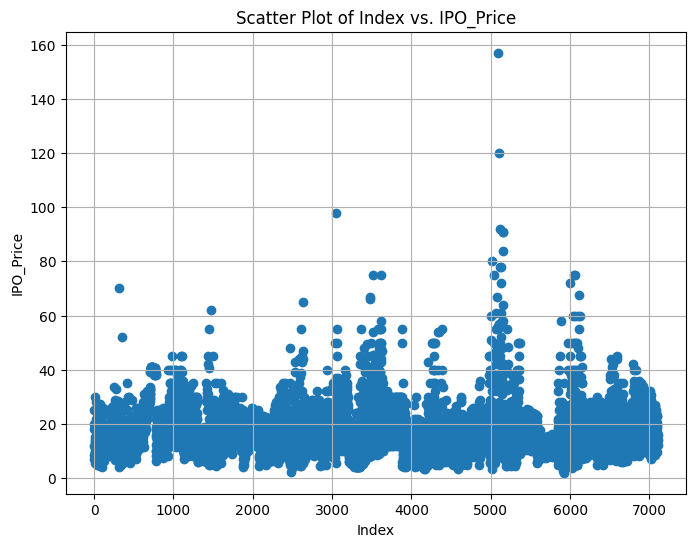

In [ ]:
print(df2.columns)
print(df2['IPO_Price'].describe())
import matplotlib.pyplot as plt

# Reset the index to make it a regular column
df2_reset = df2.reset_index()

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size as needed
plt.scatter(df2_reset.index, df2_reset['IPO_Price'])
plt.xlabel('Index')
plt.ylabel('IPO_Price')
plt.title('Scatter Plot of Index vs. IPO_Price')
plt.grid(True)
plt.show()

##3.2 Defining The Baseline Model
---------------------------------------------------------
The baseline model for this regression task would be the mean of the IPO_Prices which would be 17.63258. We then measure the metrics for the actual vs predicted results with the actual being the df2['IPO_Price'] Values and the predicted values being mean values of the IPO_Prices. The MSE,MAE,RMSE and MAPE are shown as below which are 84.45,6.40,9.19,0.45 respectively. For the machine learning model to prove its worth, it would have to be better results than the baseline model.

In [ ]:
df2 = df2.reset_index(drop=True)
features = df2[['Sector_encoded', 'Industry_encoded','Shares_Offered_encoded','Total_Revenue_encoded','Total_Asset_encoded']].values
targets = df2['IPO_Price'].values
x = torch.tensor(features, dtype=torch.float)
y = torch.tensor(targets, dtype=torch.float)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
mean_IPO_Price = df2['IPO_Price'].mean()
print(mean_IPO_Price)
baseline_predictions = [mean_IPO_Price] * len(df2)
print(baseline_predictions)
actuals = df2['IPO_Price'].values
predictions = baseline_predictions

mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)
print(mse,mae,rmse,mape)

17.632585139318884
[17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 17.632585139318884, 

##3.3 Defining the train,test sets with edges
-----------------------------------------------
We first split the dataframe into sizes 0.8 and 0.2 for the training set and test set for the graph neural network to maintain a holdout set so that the test set is unseen to the model and would not recognize hidden patterns in the test set to check if the model is accurate in estimating the IPO_Price.

The edges are defined by the indexes of the companies. For example, if company A is in the first position of the list, then it would be linked to the next company in the second position of the list so [0] -> [1] -> [2] and so on.



In [ ]:
# Check tensors for NaN values
print("NaN values in tensor x:", torch.isnan(x).sum().item())
print("NaN values in tensor y:", torch.isnan(y).sum().item())
print(x.size())
print(y.size())

train_df, test_df = train_test_split(df2, test_size=0.2, random_state=42)

def df_to_pyg_data(dtf):
    # Convert node features and target to torch tensors
    x = torch.tensor(dtf[['Sector_encoded', 'Industry_encoded','Shares_Offered_encoded','Total_Revenue_encoded','Total_Asset_encoded']].values, dtype=torch.float)
    y = torch.tensor(dtf['IPO_Price'].values, dtype=torch.long)

    # Convert edges to torch tensor
    edge_index = torch.tensor([[i, i+1] for i in range(len(dtf)-1)] + [[i+1, i] for i in range(len(dtf)-1)], dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    return data


train_data = df_to_pyg_data(train_df)
test_data = df_to_pyg_data(test_df)

train_loader = DataLoader([train_data], batch_size=32, shuffle=True)
test_loader = DataLoader([test_data], batch_size=32, shuffle=False)
print(len(train_loader))
print(len(test_loader))


NaN values in tensor x: 0
NaN values in tensor y: 0
torch.Size([7106, 5])
torch.Size([7106])
1
1


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [ ]:
def check_dataloader(loader):
    for i, batch in enumerate(loader):
        print(f"Batch {i+1}")
        print("Number of nodes:", batch.num_nodes)
        print("Number of edges:", batch.num_edges)
        print("Node features shape:", batch.x.shape)
        print("Edge indices shape:", batch.edge_index.shape)
        print("Target labels shape:", batch.y.shape)
        print("Edge index tensor:")
        print(batch.edge_index)
        print("Node features tensor:")
        print(batch.x)
        print("Target labels tensor:")
        print(batch.y)
        print("-" * 40)
        # Stop after checking one batch to avoid printing too much
        break
check_dataloader(test_loader)

Batch 1
Number of nodes: 1422
Number of edges: 2842
Node features shape: torch.Size([1422, 5])
Edge indices shape: torch.Size([2, 2842])
Target labels shape: torch.Size([1422])
Edge index tensor:
tensor([[   0,    1,    2,  ..., 1419, 1420, 1421],
        [   1,    2,    3,  ..., 1418, 1419, 1420]])
Node features tensor:
tensor([[ 5.8000e+01,  2.8000e+01, -1.2027e+00, -4.5070e-01, -4.3284e-01],
        [ 5.8000e+01,  2.8000e+01, -7.2394e-01, -5.7927e-01, -3.4612e-01],
        [ 4.8600e+02,  4.3000e+01,  3.6387e-01,  2.2477e-01, -1.6521e-02],
        ...,
        [ 5.8000e+01,  2.8000e+01, -1.2500e+00, -4.1792e-02,  3.0324e-02],
        [ 5.8000e+01,  2.8000e+01,  3.9954e-01,  4.8367e-02, -1.3666e-01],
        [ 4.6900e+02,  4.3000e+01,  1.2912e+00,  1.4503e+00,  1.5419e+00]])
Target labels tensor:
tensor([19, 14, 18,  ..., 28, 20, 24])
----------------------------------------


##3.4 Initalizing the GNN Model
-----------------------------------------------
We then setup the basic GNN model to check if it does better than the baseline model with the pytorch library and since we want the output to be a float, we add a linear layer to it which converts the neurons into a single output which is seen below.


In [ ]:
#Define the GNN model
class GNN(torch.nn.Module):
    def __init__(self):
        super(GNN, self).__init__()
        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=x.size(1), out_channels=16)
        ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=16, out_channels=8)
        self.fc = torch.nn.Linear(8, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        embeddings = x
        x = self.fc(x)
        return x

## 3.5 Training the Model
-------------------------------
The model are defined with a learning rate of 0.005 and we train it for 1000 epochs and finally we test the results to see if we have performed better than the baseline model by using the gnn model to test against the test set to see if there's better performance.

In [ ]:
# Create data loader
from torch_geometric.loader import DataLoader


# Initialize the model, loss function, and optimizer
model = GNN()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Training loop with additional checks
model.train()
for epoch in range(1000):
    for batch in train_loader:
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y.view(-1, 1).float())
        if torch.isnan(loss).sum() > 0:
            print("NaN loss encountered at epoch:", epoch)
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
    print(f'Epoch {epoch+1}, Loss: {loss.item()}')



## 3.6 Testing the Model
----------------------------------
The model shows a result of mean squared error of 91.0679, Mean Absolute Error of 6.5011 and Root Mean Squared Error of 9.5429 and Mean Absolute Percentage Error of 0.45% which shows that it is not performing better than the baseline model and we move on to developing the model further by adding in more layers of graph convolutional layer and checking if the results will improve in the next few sections.

In [ ]:
# Prediction
model.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader:
        out = model(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [14.484335899353027, 16.749313354492188, 16.192798614501953, 17.140207290649414, 16.59775161743164, 17.727035522460938, 18.97614288330078, 20.812549591064453, 19.849374771118164, 17.861469268798828, 16.39072036743164, 14.925592422485352, 13.207728385925293, 11.202143669128418, 10.484662055969238, 11.304285049438477, 13.132723808288574, 14.335678100585938, 13.458791732788086, 13.09040641784668, 13.227059364318848, 15.350441932678223, 15.163278579711914, 15.815877914428711, 16.292003631591797, 17.46430778503418, 16.267627716064453, 13.789958953857422, 13.436784744262695, 15.566360473632812, 18.244613647460938, 20.06073760986328, 18.717485427856445, 17.299633026123047, 14.970845222473145, 15.295238494873047, 16.36722755432129, 16.90863037109375, 16.476232528686523, 15.425420761108398, 15.484065055847168, 15.530073165893555, 15.397390365600586, 15.054945945739746, 15.95146369934082, 17.311328887939453, 18.07757568359375, 18.660076141357422, 16.984607696533203, 15.6157

#4 Implementation and Improving Of Models
-----------------------------------------------
For the training of the graph neural network (GNN) model, the loss function used will be the Mean Absolute Error (MAE), which measures the average absolute difference between the actual and predicted values. MAE is an important metric for evaluating model performance in regression tasks because it provides a straightforward measure of how well the model's predictions match the true values. By comparing the MAE of the GNN model to that of a baseline model, we can determine if the GNN model provides better predictive accuracy

##4.1 Improving the Edges and splitting the training set
----------------------------------------------------
We change the edges so that Companies are linked to each other by their sector and industry which we append edge index both ways which is seen from the example below to show the relation between the companies with the industry and sector:

[0] -> [1] and [1]->[0]

We also split the training set up into training set and validation set to validate the results of the training process and implement early stopping if required.

In [ ]:
def df_to_pyg_data(df):
    # Convert node features and target to torch tensors
    x = torch.tensor(df[['Sector_encoded', 'Industry_encoded','Shares_Offered_encoded','Total_Revenue_encoded','Total_Asset_encoded']].values, dtype=torch.float)
    y = torch.tensor(df['IPO_Price'].values, dtype=torch.float)
    edge_index= []
    industry_groups = df.groupby('Industry_encoded').groups
    sector_groups = df.groupby('Sector_encoded').groups
    for _, nodes in industry_groups.items():
      nodes = list(nodes)
      for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            edge_index.append((nodes[i], nodes[j]))
            edge_index.append((nodes[j], nodes[i]))
    for _, nodes in sector_groups.items():
      nodes = list(nodes)
      for i in range(len(nodes)):
        for j in range(i + 1, len(nodes)):
            edge_index.append((nodes[i], nodes[j]))
            edge_index.append((nodes[j], nodes[i]))
    # Convert edges to torch tensor
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

    # Create PyTorch Geometric Data object
    data = Data(x=x, edge_index=edge_index, y=y)
    return data

train_df,val_df = train_test_split(train_df, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_data = df_to_pyg_data(train_df)
val_data = df_to_pyg_data(val_df)
test_data = df_to_pyg_data(test_df)
train_loader2 = DataLoader([train_data], batch_size=32, shuffle=True)
val_loader2 = DataLoader([val_data],batch_size=32,shuffle=False)
test_loader2 = DataLoader([test_data], batch_size=32, shuffle=False)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## 4.2 Testing And Training the model defined in the prototype and Evaluating

In [ ]:

# Initialize the model, loss function, and optimizer
model_betterEdges = GNN()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_betterEdges.parameters(), lr=0.005)

# Early stopping parameters
patience = 10  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


# Training loop with additional checks
model_betterEdges.train()
for epoch in range(500):
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_betterEdges(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_betterEdges.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)
  print(f'Epoch {epoch+1}, Loss: {loss.item()}')

  model_betterEdges.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_betterEdges(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_betterEdges.state_dict(), 'best_model.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_betterEdges.train()

In [ ]:
# Prediction
model_betterEdges.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_betterEdges(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [16.25867462158203, 16.25867462158203, 14.796052932739258, 16.258676528930664, 9.213789939880371, 16.25867462158203, 14.796051025390625, 10.842289924621582, 14.449151992797852, 9.213791847229004, 14.796051025390625, 9.213028907775879, 9.213458061218262, 16.25867462158203, 12.710153579711914, 12.70976734161377, 16.258678436279297, 16.258668899536133, 16.25867462158203, 16.25867462158203, 10.84345817565918, 14.796051025390625, 10.84274673461914, 16.2586669921875, 16.2586727142334, 15.980449676513672, 16.25868034362793, 10.842220306396484, 16.25867462158203, 16.258676528930664, 16.2586727142334, 20.219566345214844, 16.25867462158203, 14.796051025390625, 9.21303939819336, 10.842571258544922, 14.796049118041992, 14.796051025390625, 14.44913101196289, 16.258670806884766, 16.258676528930664, 14.796049118041992, 14.796051025390625, 12.70643138885498, 14.449248313903809, 14.796051025390625, 14.796051025390625, 16.258676528930664, 14.796046257019043, 16.258676528930664, 10.

###4.2.1 Evaluation Of Model With Better Edges
-----------------------------------------
The Mean Squared Error has downgraded from 91.0679 to 103.6929,

The mean absolute error improved from 6.5011 to 6.4931,

The Root Mean Squared Error improved from 10.1830 to 9.5429,

The Mean Absolute Percentage Error improved from 0.45% to 0.38%

The model has shown more improvements in three of the metrics where only the mean squared error has downgraded which may be due to a large higher outlier which produced a large error in the test set.

##4.3 Testing And Evaluations of Other Models


### 4.3.1 Model 2
-----------------------
In model 2, we added one more graph convolutional layer.
The model consists of:

3 GCNConv Layer

1 Output Linear Layer

And we proceed to train and test the model if it is better.

In [ ]:
#Define the GNN model
class GNN2(torch.nn.Module):
    def __init__(self):
        super(GNN2, self).__init__()
        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=x.size(1), out_channels=32)
        ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=32, out_channels=16)
        self.conv3 = GCNConv(in_channels=16, out_channels=8)
        self.fc = torch.nn.Linear(8, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        embeddings = x
        x = self.fc(x)
        return x

In [ ]:

# Initialize the model, loss function, and optimizer
model_Iteration2 = GNN2()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_Iteration2.parameters(), lr=0.005)

# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


# Training loop with additional checks
model_Iteration2.train()
for epoch in range(500):
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_Iteration2(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_Iteration2.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)
  print(f'Epoch {epoch+1}, Loss: {loss.item()}')

  model_Iteration2.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_Iteration2(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_Iteration2.state_dict(), 'best_model2.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_Iteration2.train()

####4.3.1 Model 2 Evaluation
From model 2, it shows that adding a single layer with more neurons has little impact on training the model with the dataset as seen from the results showing little improvements to some of the metrics but is worse than the baseline model which can be seen from the mean absolute error of 6.40 to 6.48.

In [ ]:
# Prediction
model_Iteration2.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_Iteration2(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [16.6998348236084, 16.6998348236084, 14.252598762512207, 16.6998348236084, 9.275904655456543, 16.6998348236084, 14.252598762512207, 11.223886489868164, 15.049765586853027, 9.275906562805176, 14.252598762512207, 9.275910377502441, 9.27590560913086, 16.6998348236084, 13.487652778625488, 13.487659454345703, 16.6998348236084, 16.6998348236084, 16.6998348236084, 16.6998348236084, 11.460548400878906, 14.252598762512207, 11.223883628845215, 16.6998348236084, 16.6998348236084, 15.48996639251709, 16.6998348236084, 11.223886489868164, 16.6998348236084, 16.6998348236084, 16.6998348236084, 19.641664505004883, 16.6998348236084, 14.252598762512207, 9.275908470153809, 11.223885536193848, 14.252598762512207, 14.252598762512207, 15.049765586853027, 16.6998348236084, 16.6998348236084, 14.252598762512207, 14.252598762512207, 13.487725257873535, 15.049763679504395, 14.252598762512207, 14.252598762512207, 16.6998348236084, 14.252598762512207, 16.6998348236084, 11.460489273071289, 15.0

### 4.3.2 Model 3
From the model above, the improvements made to model 2 were the use of normalizing the outputs from the hidden layers using the batchnorm1d of pytorch library and using the dropout to set a 50% chance for some of the neurons to be set to 0 to prevent the network from being too reliant on several neurons for the output in each forward pass.

In [ ]:
#Define the GNN model
class GNN3(torch.nn.Module):
    def __init__(self):
        super(GNN3, self).__init__()
        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=x.size(1), out_channels=32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=32, out_channels=16)
        self.bn2 = torch.nn.BatchNorm1d(16)
        self.conv3 = GCNConv(in_channels=16, out_channels=8)
        self.bn3 = torch.nn.BatchNorm1d(8)
        self.fc = torch.nn.Linear(8, 1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        embeddings = x
        x = self.fc(x)
        return x

In [ ]:

# Initialize the model, loss function, and optimizer
model_Iteration3 = GNN3()
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_Iteration3.parameters(), lr=0.005)

# Early stopping parameters
patience = 15  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


for epoch in range(500):
  model_Iteration3.train()
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_Iteration3(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_Iteration3.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)


  model_Iteration3.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_Iteration3(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f},Loss: {train_loss:.4f},best_val_loss:{best_val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_Iteration3.state_dict(), 'best_model2.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_Iteration3.train()

#### 4.3.2 Model 3 Evaluation
Model 3 has shown little improvements or has downgraded from the original better metrics in model 2. It performed worse than the baseline model which can be seen from the mean absolute error of 6.40 to the model's accuracy of 6.48.



In [ ]:
# Prediction
model_Iteration3.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_Iteration3(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [15.818586349487305, 15.818586349487305, 17.578813552856445, 15.818586349487305, 14.092850685119629, 15.818586349487305, 17.578813552856445, 14.468147277832031, 14.015161514282227, 14.092851638793945, 17.578813552856445, 14.092850685119629, 14.092851638793945, 15.818586349487305, 13.16054916381836, 13.160540580749512, 15.818586349487305, 15.818586349487305, 15.818586349487305, 15.818586349487305, 14.366205215454102, 17.578813552856445, 14.468147277832031, 15.818586349487305, 15.818586349487305, 15.511839866638184, 15.818586349487305, 14.468147277832031, 15.818586349487305, 15.818586349487305, 15.818586349487305, 20.05028533935547, 15.818586349487305, 17.578811645507812, 14.092850685119629, 14.468146324157715, 17.578811645507812, 17.578813552856445, 14.015161514282227, 15.818586349487305, 15.818586349487305, 17.578811645507812, 17.578813552856445, 13.160477638244629, 14.015159606933594, 17.578813552856445, 17.578813552856445, 15.818586349487305, 17.578811645507812,

### 4.3.3 Model 4
In this model, we explore if more layers with double the neuron in the first layer will improve the model.

In [ ]:
#Define the GNN model
class GNN4(torch.nn.Module):
    def __init__(self,input_dim):
        super(GNN4, self).__init__()
        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=64)
        self.bn1 = torch.nn.BatchNorm1d(64)

       ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=64, out_channels=32)
        self.bn2 = torch.nn.BatchNorm1d(32)

        self.conv3 = GCNConv(in_channels=32, out_channels=16)
        self.bn3 = torch.nn.BatchNorm1d(16)

        self.conv4 = GCNConv(in_channels=16,out_channels=8)
        self.bn4 = torch.nn.BatchNorm1d(8)

        self.fc = torch.nn.Linear(8, 1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = self.bn4(x)
        x = F.relu(x)

        embeddings = x
        x = self.fc(x)
        return x

In [ ]:

# Initialize the model, loss function, and optimizer
model_Iteration4 = GNN4(5)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_Iteration4.parameters(), lr=0.005)

# Early stopping parameters
patience = 30  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


for epoch in range(500):
  model_Iteration4.train()
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_Iteration4(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_Iteration4.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)


  model_Iteration4.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_Iteration4(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f},Loss: {train_loss:.4f},best_val_loss:{best_val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_Iteration4.state_dict(), 'best_model2.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_Iteration4.train()

#### 4.3.3 Model 4 Evaluation
----------------------------------
The results from Model 4 is about the same as Model 3 as from the results, the metrics do not improve drastically with more neurons or having more layers. It however performed better than the baseline model in the Mean Absolute Error which is the main metrics we want to be better than the baselne model.

In [ ]:
# Prediction
model_Iteration4.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_Iteration4(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [16.878067016601562, 16.878067016601562, 14.79757022857666, 16.878067016601562, 13.869486808776855, 16.878067016601562, 14.79757022857666, 11.777496337890625, 14.107336044311523, 13.869486808776855, 14.79757022857666, 13.869486808776855, 13.869486808776855, 16.878067016601562, 14.316536903381348, 14.316536903381348, 16.878067016601562, 16.878067016601562, 16.878067016601562, 16.878067016601562, 13.517804145812988, 14.79757022857666, 11.777495384216309, 16.878067016601562, 16.878067016601562, 15.13044548034668, 16.878067016601562, 11.777496337890625, 16.878067016601562, 16.878067016601562, 16.878067016601562, 19.627227783203125, 16.878067016601562, 14.79757022857666, 13.869486808776855, 11.777496337890625, 14.79757022857666, 14.79757022857666, 14.107336044311523, 16.878067016601562, 16.878067016601562, 14.79757022857666, 14.79757022857666, 14.316536903381348, 14.107336044311523, 14.79757022857666, 14.79757022857666, 16.878067016601562, 14.79757022857666, 16.8780670

In [ ]:
#Define the GNN model
class GNN6(torch.nn.Module):
    def __init__(self,input_dim):
        super(GNN6, self).__init__()
        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=32)
        self.bn1 = torch.nn.BatchNorm1d(32)

        ##adding a hidden layer
        self.fc_hidden = torch.nn.Linear(32, 16)
        self.bn_hidden = torch.nn.BatchNorm1d(16)

       ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=16, out_channels=8)
        self.bn2 = torch.nn.BatchNorm1d(8)

        self.conv3 = GCNConv(in_channels=8, out_channels=4)
        self.bn3 = torch.nn.BatchNorm1d(4)

        self.fc = torch.nn.Linear(4, 1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc_hidden(x)
        x = self.bn_hidden(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x,edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        embeddings = x
        x = self.fc(x)
        return x

### 4.3.4 Final Model Test
-----------------------------------
This model consists of :    
- 3 convolutional layer (minus one from the previous)
- two linear layers ( one for output and one inbetween)
- 4 normalization processes
- 4 Relu activation function

We shall see if this model works better than the baseline model with the full training without early stopping to check if it is better.


In [ ]:

# Initialize the model, loss function, and optimizer
model_Iteration6 = GNN6(5)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_Iteration6.parameters(), lr=0.005)

# Early stopping parameters
patience = 500  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


for epoch in range(500):
  model_Iteration6.train()
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_Iteration6(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_Iteration6.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)


  model_Iteration6.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_Iteration6(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f},Loss: {train_loss:.4f},best_val_loss:{best_val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_Iteration6.state_dict(), 'best_model2.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_Iteration6.train()

#### 4.3.4 Final Model Evaluation
---------------------------------------
The Mean Squared Error is worst than the baseline model which is 84.45 as compared to the model's result of 95.58

The Mean Absolute error is slightly better than the Mean Absolute Error of the baseline model as seen from 6.40 to 6.38 of the final model's Mean Absolute Error

The Root Mean Squared Error of the model's 9.7765 is worse than the Baseline model's 9.19.

The Mean Absolute Percentage Error is better than the Baseline's model as seen from the model's Mean Absolute Percentage error of 0.40 to the Baseline Model's Mean Absolute Percentage Error of 0.45

Therefore, the model might still be making a large error due to outliers in the dataset but is still more accurate in predicting the IPO_Prices. With this result, we begin to test for the best model's parameters.

In [ ]:
# Prediction
model_Iteration6.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_Iteration6(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [18.463668823242188, 18.463668823242188, 16.019189834594727, 18.463668823242188, 13.359572410583496, 18.463668823242188, 16.019189834594727, 13.097433090209961, 13.497237205505371, 13.35957145690918, 16.019189834594727, 13.359572410583496, 13.35957145690918, 18.463668823242188, 13.444790840148926, 13.444786071777344, 18.463668823242188, 18.463668823242188, 18.463668823242188, 18.463668823242188, 13.173151969909668, 16.019189834594727, 13.097432136535645, 18.463668823242188, 18.463668823242188, 16.47368812561035, 18.463668823242188, 13.097433090209961, 18.463668823242188, 18.463668823242188, 18.463668823242188, 17.71795654296875, 18.463668823242188, 16.019189834594727, 13.359572410583496, 13.097433090209961, 16.019189834594727, 16.019189834594727, 13.497237205505371, 18.463668823242188, 18.463668823242188, 16.019189834594727, 16.019189834594727, 13.444742202758789, 13.497236251831055, 16.019189834594727, 16.019189834594727, 18.463668823242188, 16.019189834594727, 1

### 5 Hypertuning the Parameters using Grid Search
------------------------------------------------------
For the best parameters of the model, we first define the set of parameters that we need to test which are:

-output_size:32,64,128

-learning_rate:0.001,0.005,0.01

-optimizer:sgd,adam

-dropout_rate: 0.3,0.5,0.7
we then do a grid search to see which yields the best validation loss for the final model and see if it performs better results than the final model.

In [ ]:
hyperparameter = {
    'output_size': [32],  # Different sizes for the hidden layer
    'learning_rate': [0.001, 0.005, 0.01],  # Different learning rates
    'optimizer': ['sgd','adam'],  # Different optimizers
    'dropout_rate': [0.3, 0.5, 0.7]  # Different dropout rates
}

#variable to keep the results of hypertuning parameters
best_params = None
best_loss = float('inf')

# Generate all combinations of hyperparameters as a list
hyperparameter_combinations = list(itertools.product(
    hyperparameter['output_size'],
    hyperparameter['learning_rate'],
    hyperparameter['optimizer'],
    hyperparameter['dropout_rate']
))

In [ ]:
#Define the GNN model
class GNN6(torch.nn.Module):
    def __init__(self,input_dim,output_size,dropout_rate):
        super(GNN6, self).__init__()

        assert output_size % 8 == 0, "Output size should be divisible by 8."

        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=output_size)
        self.bn1 = torch.nn.BatchNorm1d(output_size)

        ##adding a hidden layer
        self.fc_hidden = torch.nn.Linear(output_size, output_size//2)
        self.bn_hidden = torch.nn.BatchNorm1d(output_size//2)

       ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=output_size//2, out_channels=output_size//4)
        self.bn2 = torch.nn.BatchNorm1d(output_size//4)

        self.conv3 = GCNConv(in_channels=output_size//4, out_channels=output_size//8)
        self.bn3 = torch.nn.BatchNorm1d(output_size//8)

        self.fc = torch.nn.Linear(output_size//8, 1)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc_hidden(x)
        x = self.bn_hidden(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x,edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        embeddings = x
        x = self.fc(x)
        return x

In [ ]:
def train_and_evaluate(output_size, learning_rate, optimizer_name, dropout_rate):
    # Initialize the model with given hyperparameters
    model = GNN6(input_dim=5, output_size=output_size, dropout_rate=dropout_rate)
    print(f'Currently Testing Model:{output_size},{learning_rate},{optimizer_name},{dropout_rate}')

    # Define the optimizer
    if optimizer_name == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Loss function
    criterion = torch.nn.L1Loss()

    # Early stopping parameters
    patience = 500
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Training loop
    for epoch in range(500):
        model.train()
        train_loss = 0
        for batch in train_loader2:
            optimizer.zero_grad()
            out = model(batch)
            loss = criterion(out, batch.y.view(-1, 1).float())
            if torch.isnan(loss).sum() > 0:
                print("NaN loss encountered at epoch:", epoch)
                return float('inf')  # Return infinity to indicate a failed run
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item() * batch.num_graphs
        train_loss /= len(train_loader2.dataset)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader2:
                out = model(batch)
                loss = criterion(out, batch.y.view(-1, 1).float())
                val_loss += loss.item() * batch.num_graphs
        val_loss /= len(val_loader2.dataset)

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            break

    return best_val_loss

In [ ]:
for output_size, learning_rate, optimizer_name, dropout_rate in hyperparameter_combinations:
    val_loss = train_and_evaluate(output_size, learning_rate, optimizer_name, dropout_rate)

    print(f"Tested params: hidden_layer_size={output_size}, learning_rate={learning_rate}, optimizer={optimizer_name}, dropout_rate={dropout_rate}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {
            'hidden_layer_size': output_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'dropout_rate': dropout_rate
        }

print(f"Best hyperparameters: {best_params}, Best Validation Loss: {best_loss:.4f}")

Currently Testing Model:32,0.001,sgd,0.3
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=sgd, dropout_rate=0.3, Validation Loss: 16.8614
Currently Testing Model:32,0.001,sgd,0.5
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=sgd, dropout_rate=0.5, Validation Loss: 17.4447
Currently Testing Model:32,0.001,sgd,0.7
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=sgd, dropout_rate=0.7, Validation Loss: 17.2153
Currently Testing Model:32,0.001,adam,0.3
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=adam, dropout_rate=0.3, Validation Loss: 14.0265
Currently Testing Model:32,0.001,adam,0.5
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=adam, dropout_rate=0.5, Validation Loss: 13.8530
Currently Testing Model:32,0.001,adam,0.7
Tested params: hidden_layer_size=32, learning_rate=0.001, optimizer=adam, dropout_rate=0.7, Validation Loss: 12.6520
Currently Testing Model:32,0.005,sgd,0.3
Tested para

In [ ]:
hyperparameter = {
    'output_size': [64],  # Different sizes for the hidden layer
    'learning_rate': [0.001, 0.005, 0.01],  # Different learning rates
    'optimizer': ['sgd','adam'],  # Different optimizers
    'dropout_rate': [0.3, 0.5, 0.7]  # Different dropout rates
}

#variable to keep the results of hypertuning parameters
best_params = None
best_loss = float('inf')

# Generate all combinations of hyperparameters as a list
hyperparameter_combinations = list(itertools.product(
    hyperparameter['output_size'],
    hyperparameter['learning_rate'],
    hyperparameter['optimizer'],
    hyperparameter['dropout_rate']
))

In [ ]:
for output_size, learning_rate, optimizer_name, dropout_rate in hyperparameter_combinations:
    val_loss = train_and_evaluate(output_size, learning_rate, optimizer_name, dropout_rate)

    print(f"Tested params: hidden_layer_size={output_size}, learning_rate={learning_rate}, optimizer={optimizer_name}, dropout_rate={dropout_rate}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {
            'hidden_layer_size': output_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'dropout_rate': dropout_rate
        }

print(f"Best hyperparameters: {best_params}, Best Validation Loss: {best_loss:.4f}")

Currently Testing Model:64,0.001,sgd,0.3
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=sgd, dropout_rate=0.3, Validation Loss: 17.3035
Currently Testing Model:64,0.001,sgd,0.5
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=sgd, dropout_rate=0.5, Validation Loss: 17.6141
Currently Testing Model:64,0.001,sgd,0.7
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=sgd, dropout_rate=0.7, Validation Loss: 17.0669
Currently Testing Model:64,0.001,adam,0.3
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=adam, dropout_rate=0.3, Validation Loss: 13.0815
Currently Testing Model:64,0.001,adam,0.5
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=adam, dropout_rate=0.5, Validation Loss: 12.9676
Currently Testing Model:64,0.001,adam,0.7
Tested params: hidden_layer_size=64, learning_rate=0.001, optimizer=adam, dropout_rate=0.7, Validation Loss: 12.5463
Currently Testing Model:64,0.005,sgd,0.3
Tested para

In [ ]:
hyperparameter = {
    'output_size': [128],  # Different sizes for the hidden layer
    'learning_rate': [ 0.001,0.005,0.01],  # Different learning rates
    'optimizer': ['sgd','adam'],  # Different optimizers
    'dropout_rate': [0.3, 0.5, 0.7]  # Different dropout rates
}

#variable to keep the results of hypertuning parameters
best_params = None
best_loss = float('inf')

# Generate all combinations of hyperparameters as a list
hyperparameter_combinations = list(itertools.product(
    hyperparameter['output_size'],
    hyperparameter['learning_rate'],
    hyperparameter['optimizer'],
    hyperparameter['dropout_rate']
))

In [ ]:
for output_size, learning_rate, optimizer_name, dropout_rate in hyperparameter_combinations:
    val_loss = train_and_evaluate(output_size, learning_rate, optimizer_name, dropout_rate)

    print(f"Tested params: hidden_layer_size={output_size}, learning_rate={learning_rate}, optimizer={optimizer_name}, dropout_rate={dropout_rate}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {
            'hidden_layer_size': output_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'dropout_rate': dropout_rate
        }

print(f"Best hyperparameters: {best_params}, Best Validation Loss: {best_loss:.4f}")

Currently Testing Model:128,0.001,sgd,0.3
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=sgd, dropout_rate=0.3, Validation Loss: 17.6764
Currently Testing Model:128,0.001,sgd,0.5
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=sgd, dropout_rate=0.5, Validation Loss: 16.9914
Currently Testing Model:128,0.001,sgd,0.7
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=sgd, dropout_rate=0.7, Validation Loss: 17.2065
Currently Testing Model:128,0.001,adam,0.3
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=adam, dropout_rate=0.3, Validation Loss: 9.7367
Currently Testing Model:128,0.001,adam,0.5
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=adam, dropout_rate=0.5, Validation Loss: 8.3406
Currently Testing Model:128,0.001,adam,0.7
Tested params: hidden_layer_size=128, learning_rate=0.001, optimizer=adam, dropout_rate=0.7, Validation Loss: 7.9024
Currently Testing Model:128,0.005,sgd,0.3
T

In [ ]:
hyperparameter = {
    'output_size': [128],  # Different sizes for the hidden layer
    'learning_rate': [ 0.01],  # Different learning rates
    'optimizer': ['adam'],  # Different optimizers
    'dropout_rate': [0.3, 0.5, 0.7]  # Different dropout rates
}

#variable to keep the results of hypertuning parameters
best_params = None
best_loss = float('inf')

# Generate all combinations of hyperparameters as a list
hyperparameter_combinations = list(itertools.product(
    hyperparameter['output_size'],
    hyperparameter['learning_rate'],
    hyperparameter['optimizer'],
    hyperparameter['dropout_rate']
))

In [ ]:
for output_size, learning_rate, optimizer_name, dropout_rate in hyperparameter_combinations:
    val_loss = train_and_evaluate(output_size, learning_rate, optimizer_name, dropout_rate)

    print(f"Tested params: hidden_layer_size={output_size}, learning_rate={learning_rate}, optimizer={optimizer_name}, dropout_rate={dropout_rate}, Validation Loss: {val_loss:.4f}")

    if val_loss < best_loss:
        best_loss = val_loss
        best_params = {
            'hidden_layer_size': output_size,
            'learning_rate': learning_rate,
            'optimizer': optimizer_name,
            'dropout_rate': dropout_rate
        }

print(f"Best hyperparameters: {best_params}, Best Validation Loss: {best_loss:.4f}")

Currently Testing Model:128,0.01,adam,0.3
Tested params: hidden_layer_size=128, learning_rate=0.01, optimizer=adam, dropout_rate=0.3, Validation Loss: 6.0825
Currently Testing Model:128,0.01,adam,0.5
Tested params: hidden_layer_size=128, learning_rate=0.01, optimizer=adam, dropout_rate=0.5, Validation Loss: 6.0972
Currently Testing Model:128,0.01,adam,0.7
Tested params: hidden_layer_size=128, learning_rate=0.01, optimizer=adam, dropout_rate=0.7, Validation Loss: 6.1021
Best hyperparameters: {'hidden_layer_size': 128, 'learning_rate': 0.01, 'optimizer': 'adam', 'dropout_rate': 0.3}, Best Validation Loss: 6.0825


In [ ]:
# Example of a new model architecture
class GNN_New(torch.nn.Module):
    def __init__(self, num_features):
        super(GNN_New, self).__init__()
        self.conv1 = GATConv(num_features, 32, heads=4, dropout=0.6)
        self.conv2 = GATConv(32 * 4, 16, heads=4, dropout=0.6, concat=False)
        self.fc = torch.nn.Linear(16, 1)  # Output layer

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = F.elu(self.conv1(x, edge_index))
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = self.fc(x)
        return x

In [ ]:
model_new = GNN_New(5)
criterion = torch.nn.L1Loss()
optimizer_new = torch.optim.Adam(model_new.parameters(), lr=0.001)

In [ ]:
# Early stopping parameters for the new model
patience = 500
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(500):
    model_new.train()
    train_loss = 0
    for batch in train_loader2:
        optimizer_new.zero_grad()
        out = model_new(batch)
        loss = criterion(out, batch.y.view(-1, 1).float())
        if torch.isnan(loss).sum() > 0:
            print("NaN loss encountered at epoch:", epoch)
            break
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_new.parameters(), max_norm=1.0)
        optimizer_new.step()
        train_loss += loss.item() * batch.num_graphs
    train_loss /= len(train_loader2.dataset)

    model_new.eval()
    val_loss = 0

    with torch.no_grad():
        for batch in val_loader2:
            out = model_new(batch)
            loss = criterion(out, batch.y.view(-1, 1).float())
            val_loss += loss.item() * batch.num_graphs

    val_loss /= len(val_loader2.dataset)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f}, Loss: {train_loss:.4f}, Best Val Loss: {best_val_loss:.4f}')

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model_new.state_dict(), 'best_model_new.pt')
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= patience:
        print(f'Early stopping triggered after {epoch+1} epochs')
        break

    model_new.train()

Epoch 1, Validation Loss: 15.0199, Loss: 13.3472, Best Val Loss: inf
Epoch 2, Validation Loss: 14.8903, Loss: 17.2816, Best Val Loss: 15.0199
Epoch 3, Validation Loss: 14.7341, Loss: 17.4908, Best Val Loss: 14.8903
Epoch 4, Validation Loss: 14.5739, Loss: 15.0697, Best Val Loss: 14.7341
Epoch 5, Validation Loss: 14.3585, Loss: 15.5761, Best Val Loss: 14.5739
Epoch 6, Validation Loss: 14.1501, Loss: 12.3918, Best Val Loss: 14.3585
Epoch 7, Validation Loss: 14.0474, Loss: 14.4163, Best Val Loss: 14.1501
Epoch 8, Validation Loss: 14.0497, Loss: 15.2335, Best Val Loss: 14.0474
Epoch 9, Validation Loss: 14.0735, Loss: 13.5437, Best Val Loss: 14.0474
Epoch 10, Validation Loss: 14.1802, Loss: 13.8939, Best Val Loss: 14.0474
Epoch 11, Validation Loss: 14.2783, Loss: 11.0504, Best Val Loss: 14.0474
Epoch 12, Validation Loss: 14.2822, Loss: 11.0917, Best Val Loss: 14.0474
Epoch 13, Validation Loss: 14.3120, Loss: 11.5638, Best Val Loss: 14.0474
Epoch 14, Validation Loss: 14.2606, Loss: 11.3003, 

In [ ]:
# Prediction
model_new.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_new(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}')

Predicted valuations: [21.804887771606445, 21.804889678955078, 34.936466217041016, 21.804889678955078, 19.9669189453125, 21.804887771606445, 27.818143844604492, 18.25661849975586, 21.746299743652344, 19.966873168945312, 27.631914138793945, 19.889678955078125, 19.89610481262207, 21.804887771606445, 17.08754539489746, 17.098899841308594, 21.804889678955078, 23.366872787475586, 21.804887771606445, 21.804885864257812, 16.95244598388672, 27.818143844604492, 18.246238708496094, 23.366870880126953, 21.83098602294922, 35.235755920410156, 21.804889678955078, 18.25661849975586, 21.804887771606445, 21.804889678955078, 21.791351318359375, 38.872833251953125, 21.804887771606445, 27.860628128051758, 19.889671325683594, 18.289207458496094, 27.85369873046875, 27.67658805847168, 21.77044677734375, 21.79109001159668, 21.804889678955078, 27.86063003540039, 34.936466217041016, 17.170284271240234, 22.82923126220703, 27.676589965820312, 27.676589965820312, 21.804889678955078, 27.854129791259766, 21.80488967

##5.1 Hypertuning Results
The results of running several tests show that as the model behaves best with adam and the best results come from the learning rate of 0.01 and hidden_layer_size of 128 and dropout = 0.3. The validation loss of 6.0825 was the best performing out of all the models. Therefore, we shall implement to see if it surpasses the final model's metrics.

In [ ]:
#Define the GNN model
class GNN6(torch.nn.Module):
    def __init__(self,input_dim,output_size,dropout_rate):
        super(GNN6, self).__init__()

        assert output_size % 8 == 0, "Output size should be divisible by 8."

        ###convolutional layer 1 to extract richer features from the data
        self.conv1 = GCNConv(in_channels=input_dim, out_channels=output_size)
        self.bn1 = torch.nn.BatchNorm1d(output_size)

        ##adding a hidden layer
        self.fc_hidden = torch.nn.Linear(output_size, output_size//2)
        self.bn_hidden = torch.nn.BatchNorm1d(output_size//2)

       ### convolutional layer 2 further refining these features into a more compact form.
        self.conv2 = GCNConv(in_channels=output_size//2, out_channels=output_size//4)
        self.bn2 = torch.nn.BatchNorm1d(output_size//4)

        self.conv3 = GCNConv(in_channels=output_size//4, out_channels=output_size//8)
        self.bn3 = torch.nn.BatchNorm1d(output_size//8)

        self.fc = torch.nn.Linear(output_size//8, 1)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc_hidden(x)
        x = self.bn_hidden(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x,edge_index)
        x = self.bn3(x)
        x = F.relu(x)

        embeddings = x
        x = self.fc(x)
        return x

In [ ]:

# Initialize the model, loss function, and optimizer
model_Iteration6 = GNN6(input_dim=5,output_size=128,dropout_rate=0.3)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model_Iteration6.parameters(), lr=0.01)

# Early stopping parameters
patience = 500  # Number of epochs to wait for improvement
best_val_loss = float('inf')  # Initialize with a large value
epochs_no_improve = 0  # Count of epochs since the last improvement


for epoch in range(500):
  model_Iteration6.train()
  train_loss = 0
  for batch in train_loader2:
      optimizer.zero_grad()
      out = model_Iteration6(batch)
      loss = criterion(out, batch.y.view(-1, 1).float())
      if torch.isnan(loss).sum() > 0:
          print("NaN loss encountered at epoch:", epoch)
          break
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model_Iteration6.parameters(), max_norm=1.0)
      optimizer.step()
      train_loss += loss.item() * batch.num_graphs
  train_loss /= len(train_loader2.dataset)


  model_Iteration6.eval()  # Set the model to evaluation mode
  val_loss = 0  # Initialize validation loss

  with torch.no_grad():  # No gradient computation
      for batch in val_loader2:
          out = model_Iteration6(batch)  # Forward pass
          loss = criterion(out, batch.y.view(-1, 1).float())  # Compute loss
          val_loss += loss.item() * batch.num_graphs  # Accumulate validation loss

  val_loss /= len(val_loader2.dataset)  # Average validation loss
  print(f'Epoch {epoch+1}, Validation Loss: {val_loss:.4f},Loss: {train_loss:.4f},best_val_loss:{best_val_loss:.4f}')

  # Early stopping check
  if val_loss < best_val_loss:
      best_val_loss = val_loss
      epochs_no_improve = 0
      # Save the best model
      torch.save(model_Iteration6.state_dict(), 'best_model2.pt')
  else:
      epochs_no_improve += 1

    # Check if early stopping criterion is met
  if epochs_no_improve >= patience:
      print(f'Early stopping triggered after {epoch+1} epochs')
      break

    # Set the model back to training mode for the next epoch
  model_Iteration6.train()

Epoch 1, Validation Loss: 17.6688,Loss: 18.1387,best_val_loss:inf
Epoch 2, Validation Loss: 17.7254,Loss: 18.1074,best_val_loss:17.6688
Epoch 3, Validation Loss: 17.8026,Loss: 17.9677,best_val_loss:17.6688
Epoch 4, Validation Loss: 17.7017,Loss: 17.8273,best_val_loss:17.6688
Epoch 5, Validation Loss: 17.4649,Loss: 17.7500,best_val_loss:17.6688
Epoch 6, Validation Loss: 17.1846,Loss: 17.6232,best_val_loss:17.4649
Epoch 7, Validation Loss: 17.0183,Loss: 17.5306,best_val_loss:17.1846
Epoch 8, Validation Loss: 16.8864,Loss: 17.4360,best_val_loss:17.0183
Epoch 9, Validation Loss: 16.7620,Loss: 17.3477,best_val_loss:16.8864
Epoch 10, Validation Loss: 16.6574,Loss: 17.2520,best_val_loss:16.7620
Epoch 11, Validation Loss: 16.5290,Loss: 17.1641,best_val_loss:16.6574
Epoch 12, Validation Loss: 16.3872,Loss: 17.0699,best_val_loss:16.5290
Epoch 13, Validation Loss: 16.2636,Loss: 16.9728,best_val_loss:16.3872
Epoch 14, Validation Loss: 16.1721,Loss: 16.8779,best_val_loss:16.2636
Epoch 15, Validatio

In [ ]:
# Prediction
model_Iteration6.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader2:
        out = model_Iteration6(batch)
        predictions.extend(out.squeeze().cpu().numpy().tolist())

print(f'Predicted valuations: {predictions}')

# Evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Convert predictions and targets to numpy arrays for evaluation
actuals = test_data.y.numpy()

# Calculate evaluation metrics
mse = mean_squared_error(actuals, predictions)
mae = mean_absolute_error(actuals, predictions)
rmse = mean_squared_error(actuals, predictions, squared=False)
mape = mean_absolute_percentage_error(actuals, predictions)


print(f'Mean Squared Error: {mse:.4f}')
print(f'Mean Absolute Error: {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Predicted valuations: [17.00674057006836, 17.00674057006836, 15.634843826293945, 17.00674057006836, 9.443140983581543, 17.00674057006836, 15.76291561126709, 13.243549346923828, 11.65355396270752, 9.443140029907227, 15.92860221862793, 9.48320484161377, 9.498150825500488, 17.00674057006836, 13.279548645019531, 13.177889823913574, 17.00674057006836, 15.633118629455566, 17.00674057006836, 17.00674057006836, 15.416971206665039, 15.76291561126709, 13.249523162841797, 15.633118629455566, 15.484336853027344, 15.388965606689453, 17.00674057006836, 13.243524551391602, 17.00674057006836, 17.00674057006836, 15.600032806396484, 17.897661209106445, 17.00674057006836, 15.747207641601562, 9.483203887939453, 13.176414489746094, 15.705995559692383, 15.874368667602539, 11.660080909729004, 15.602745056152344, 17.00674057006836, 15.747207641601562, 15.634843826293945, 13.023650169372559, 11.601829528808594, 15.874368667602539, 15.874368667602539, 17.00674057006836, 15.705995559692383, 17.00674057006836, 15

##6 Evaluation Of The GNN Model
----------------------------
Despite training the model with better edges, hypertuning the parameters, the graph neural network appears to perform only slightly better than the baseline model but still is not satisfactory for the project's purpose of identifying the IPO Prices based on the factors such as revenue, owner's equity and total assets of the company.

Next, we shall explore if MLP is better than the Graph Neural Network in defining the IPO_Price.

##7 Multilayer Perceptron
----------------------------
Building the Multilayer Perceptron from a simple Multilayer Perceptron and explore the network deeper to see if building a deeper network will better fit the purpose of determining the IPO_Price on the company based on the factors such as revenue, owner's equity and total assets of the company.

###7.1 Initalizing the Training/Test Set
In the following codes below, we initalise the training set and maintain the hold out set for later purposes so that we can split the training set to validation and training set again.

In [ ]:
train_df, test_df = train_test_split(df2, test_size=0.2, random_state=42)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

## Training Set
train_dfx = torch.tensor(train_df[['Sector_encoded', 'Industry_encoded','Shares_Offered_encoded','Total_Revenue_encoded','Total_Asset_encoded']].values, dtype=torch.float)
train_dfy = torch.tensor(train_df['IPO_Price'].values, dtype=torch.long)


## Test Set Hold Out Set
test_dfx = torch.tensor(test_df[['Sector_encoded', 'Industry_encoded','Shares_Offered_encoded','Total_Revenue_encoded','Total_Asset_encoded']].values, dtype=torch.float)
test_dfy = torch.tensor(test_df['IPO_Price'].values, dtype=torch.long)

FinalTrainComparisonDataset = TensorDataset(train_dfx,train_dfy)
FinalTrainComparisonloader = DataLoader(FinalTrainComparisonDataset,batch_size=32,shuffle=True)

testDataset = TensorDataset(test_dfx,test_dfy)
testloader = DataLoader(testDataset,batch_size=32,shuffle=True)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


###7.2 Building the First MLP Regression Model
------------------------------------------------
In the first model, we have two layers of linear and the last layer which takes all the neurons into a single output and a relu activation function after each layer.

In [ ]:
class MLPRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,dropout_rate=0.5):
        super(MLPRegressionModel, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim,hidden_dim//2)
        self.fcLast = torch.nn.Linear(hidden_dim//2, output_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))

        x = F.relu(self.fc2(x))




        x = self.fcLast(x)
        return x

####7.2.1 Training the Model

In [ ]:
input_dim = train_dfx.shape[1]
print(input_dim)
hidden_dim = 128
output_dim = 1

model = MLPRegressionModel(input_dim, hidden_dim, output_dim)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs =500  # Number of epochs for training

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize loss for this epoch
    total_samples = 0
    for inputs, targets in FinalTrainComparisonloader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model(inputs)  # Forward pass: compute predictions
        loss = criterion(outputs, targets.view(-1, 1).float())  # Compute loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        epoch_loss += loss.item()*inputs.size(0)  # Accumulate loss for this epoch
        total_samples += inputs.size(0)
    # Print average loss for the epoch
    avg_loss = epoch_loss/total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')


5
Epoch 1/500, Loss: 7.6291
Epoch 2/500, Loss: 6.4461
Epoch 3/500, Loss: 6.2322
Epoch 4/500, Loss: 6.1676
Epoch 5/500, Loss: 6.0240
Epoch 6/500, Loss: 5.9078
Epoch 7/500, Loss: 5.8432
Epoch 8/500, Loss: 5.7491
Epoch 9/500, Loss: 5.9748
Epoch 10/500, Loss: 5.7406
Epoch 11/500, Loss: 5.7457
Epoch 12/500, Loss: 5.6872
Epoch 13/500, Loss: 5.6217
Epoch 14/500, Loss: 5.6115
Epoch 15/500, Loss: 5.5837
Epoch 16/500, Loss: 5.5384
Epoch 17/500, Loss: 5.5537
Epoch 18/500, Loss: 5.6219
Epoch 19/500, Loss: 5.6100
Epoch 20/500, Loss: 5.5195
Epoch 21/500, Loss: 5.5252
Epoch 22/500, Loss: 5.5107
Epoch 23/500, Loss: 5.5093
Epoch 24/500, Loss: 5.4625
Epoch 25/500, Loss: 5.4699
Epoch 26/500, Loss: 5.4474
Epoch 27/500, Loss: 5.4562
Epoch 28/500, Loss: 5.5083
Epoch 29/500, Loss: 5.4585
Epoch 30/500, Loss: 5.4990
Epoch 31/500, Loss: 5.4642
Epoch 32/500, Loss: 5.4538
Epoch 33/500, Loss: 5.4647
Epoch 34/500, Loss: 5.4830
Epoch 35/500, Loss: 5.4175
Epoch 36/500, Loss: 5.4659
Epoch 37/500, Loss: 5.4959
Epoch 38

#### 7.2.2 Evaluation Of the Initial Model
The model did better than the baseline model and the final Graph Neural Network Model as seen from the metrics such as the mean squared error,

From the model below, the results from the evaluation are as follows:


MAE:5.66

MSE:96.91

RMSE:9.84

MAPE:0.3742

Baseline Model's Results:

MAE:6.40

MSE:84.45

RMSE:9.18

MAPE:0.4531


In [ ]:
model.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate loss
total_loss = 0
n_batches = 0

all_actuals = []
all_predictions = []
all_differences = []


with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in testloader:
        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        # Compute the loss
        differences = targets.view(-1,1) - outputs

        all_actuals.extend(targets.detach().cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_differences.extend(differences.detach().cpu().numpy())
        # Accumulate loss
        total_loss += loss.item()
        n_batches += 1


all_actuals_tensor = torch.tensor(all_actuals, dtype=torch.float32)
all_predictions_tensor = torch.tensor(all_predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
mse = mse_loss(all_predictions_tensor, all_actuals_tensor.view(-1, 1))
print(f'Mean Squared Error (MSE) using nn.MSELoss: {mse.item():.4f}')

mae_loss = torch.nn.L1Loss()
mae=mae_loss(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Error (MAE) using nn.L1Loss: {mae.item():.4f}')


rmse = mean_squared_error(all_predictions_tensor,all_actuals_tensor.view(-1,1), squared=False)
print(f'Root Mean Squared Error (rmse): {rmse.item():.4f}')



mape = mean_absolute_percentage_error(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Percentage Error (MAE): {mape.item():.4f}')


Mean Squared Error (MSE) using nn.MSELoss: 96.9109
Mean Absolute Error (MAE) using nn.L1Loss: 5.6575
Root Mean Squared Error (rmse): 9.8443
Mean Absolute Percentage Error (MAE): 0.3742


### 7.3 Building A Deeper Network
---------------------------------------
For this network, we shall include few more layers without normalizing and dropping out. The network is as follows:

X --> hidden layer --> Relu --> Hidden layer --> Relu --> Hidden layer --> Relu --> Hidden Layer --> Relu --> Output



In this model, there are four hidden layers and one final layer to convert the input neurons into a single output.


In [ ]:
class MLPRegressionModel2(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,dropout_rate=0.5):
        super(MLPRegressionModel2, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = torch.nn.Linear(hidden_dim//2, hidden_dim//4)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim//4)
        self.fc4 = torch.nn.Linear(hidden_dim//4, hidden_dim//8)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim//8)
        self.fcLast = torch.nn.Linear(hidden_dim//8, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        x = F.relu(self.fc1(x))


        x = F.relu(self.fc2(x))


        x = F.relu(self.fc3(x))


        x = F.relu(self.fc4(x))


        x = self.fcLast(x)
        return x

####7.3.1 Training The Second MLP Model
-------------------------------------------
Below is the code to train the MLP model with the training set.

In [ ]:
input_dim = train_dfx.shape[1]
print(input_dim)
hidden_dim = 128
output_dim = 1

model2 = MLPRegressionModel2(input_dim, hidden_dim, output_dim)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)

# Training loop
num_epochs =500  # Number of epochs for training

for epoch in range(num_epochs):
    model2.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize loss for this epoch
    total_samples = 0
    for inputs, targets in FinalTrainComparisonloader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model2(inputs)  # Forward pass: compute predictions
        loss = criterion(outputs, targets.view(-1, 1).float())  # Compute loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights
        torch.nn.utils.clip_grad_norm_(model2.parameters(), max_norm=1.0)
        epoch_loss += loss.item()*inputs.size(0)  # Accumulate loss for this epoch
        total_samples += inputs.size(0)
    # Print average loss for the epoch
    avg_loss = epoch_loss/total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    model2.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    total_val_samples = 0



5
Epoch 1/500, Loss: 7.3723
Epoch 2/500, Loss: 6.3809
Epoch 3/500, Loss: 6.2426
Epoch 4/500, Loss: 6.0299
Epoch 5/500, Loss: 5.8499
Epoch 6/500, Loss: 5.7461
Epoch 7/500, Loss: 5.6843
Epoch 8/500, Loss: 5.6575
Epoch 9/500, Loss: 5.6320
Epoch 10/500, Loss: 5.6327
Epoch 11/500, Loss: 5.5923
Epoch 12/500, Loss: 5.6492
Epoch 13/500, Loss: 5.5531
Epoch 14/500, Loss: 5.5283
Epoch 15/500, Loss: 5.5840
Epoch 16/500, Loss: 5.5760
Epoch 17/500, Loss: 5.5614
Epoch 18/500, Loss: 5.5281
Epoch 19/500, Loss: 5.4892
Epoch 20/500, Loss: 5.5419
Epoch 21/500, Loss: 5.4879
Epoch 22/500, Loss: 5.5320
Epoch 23/500, Loss: 5.4805
Epoch 24/500, Loss: 5.5121
Epoch 25/500, Loss: 5.5672
Epoch 26/500, Loss: 5.4856
Epoch 27/500, Loss: 5.4951
Epoch 28/500, Loss: 5.5322
Epoch 29/500, Loss: 5.4703
Epoch 30/500, Loss: 5.4964
Epoch 31/500, Loss: 5.5090
Epoch 32/500, Loss: 5.4550
Epoch 33/500, Loss: 5.5075
Epoch 34/500, Loss: 5.5090
Epoch 35/500, Loss: 5.4665
Epoch 36/500, Loss: 5.4621
Epoch 37/500, Loss: 5.4323
Epoch 38

####7.3.2 Evaluation Of the Second MLP Model

The model did better than the baseline model and the final Graph Neural Network Model but worst than the initial simple MLP model as seen from the metrics such as the mean squared error,

From the model below, the results from the evaluation are as follows:

MAE:5.73

MSE:80.4365

RMSE:8.9686

MAPE:0.3373


Initial MLP Model's Results:

MAE:5.66

MSE:96.91

RMSE:9.84

MAPE:0.3742

Baseline Model's Results:

MAE:6.40

MSE:84.45

RMSE:9.18

MAPE:0.4531

In [ ]:
model2.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate loss
total_loss = 0
n_batches = 0

all_actuals = []
all_predictions = []
all_differences = []


with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in testloader:
        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model2(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        # Compute the loss
        differences = targets.view(-1,1) - outputs

        all_actuals.extend(targets.detach().cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_differences.extend(differences.detach().cpu().numpy())
        # Accumulate loss
        total_loss += loss.item()
        n_batches += 1


all_actuals_tensor = torch.tensor(all_actuals, dtype=torch.float32)
all_predictions_tensor = torch.tensor(all_predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
mse = mse_loss(all_predictions_tensor, all_actuals_tensor.view(-1, 1))
print(f'Mean Squared Error (MSE) using nn.MSELoss: {mse.item():.4f}')

mae_loss = torch.nn.L1Loss()
mae=mae_loss(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Error (MAE) using nn.L1Loss: {mae.item():.4f}')


rmse = mean_squared_error(all_predictions_tensor,all_actuals_tensor.view(-1,1), squared=False)
print(f'Root Mean Squared Error (rmse): {rmse.item():.4f}')



mape = mean_absolute_percentage_error(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Percentage Error (MAE): {mape.item():.4f}')


Mean Squared Error (MSE) using nn.MSELoss: 80.4365
Mean Absolute Error (MAE) using nn.L1Loss: 5.7308
Root Mean Squared Error (rmse): 8.9686
Mean Absolute Percentage Error (MAE): 0.3373


####7.3.3 K-Fold Cross Validation

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []
criterion = torch.nn.L1Loss()

all_training_losses=[]
all_val_losses =[]

##MLP 2


for fold, (train_index, val_index) in enumerate(kf.split(train_dfx)):
    print(f'Fold {fold + 1}/{k}')

    # Prepare train and validation data
    X_train, X_val = train_dfx[train_index], train_dfx[val_index]
    y_train, y_val = train_dfy[train_index], train_dfy[val_index]

    # Create datasets and dataloaders for each fold
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize the model, optimizer
    model2 = MLPRegressionModel2(input_dim=5, hidden_dim=128, output_dim=1)
    optimizer = torch.optim.Adam(model2.parameters(), lr=0.01)


    # initalize lists to store losses for this fold
    fold_train_losses = []
    fold_val_losses = []


    for epoch in range(100):  # Number of epochs, adjust as needed
        model2.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        fold_train_losses.append(avg_train_loss)

        model2.eval()
        val_loss = 0.0
        with torch.no_grad():
          for inputs, targets in val_loader:
            outputs = model2(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

          avg_val_loss = val_loss / len(val_loader)
          fold_val_losses.append(avg_val_loss)
          fold_results.append(avg_val_loss)


        # Append the losses for this fold to the overall lists
        all_training_losses.append(fold_train_losses)
        all_val_losses.append(fold_val_losses)


# Average validation MAE across all folds
mean_val_loss = np.mean(fold_results)
print(f'Average Validation MAE across {k} folds: {mean_val_loss:.4f}')

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 5.5743


####7.3.4 Plotting the Graph Of Training VS Validation Losses



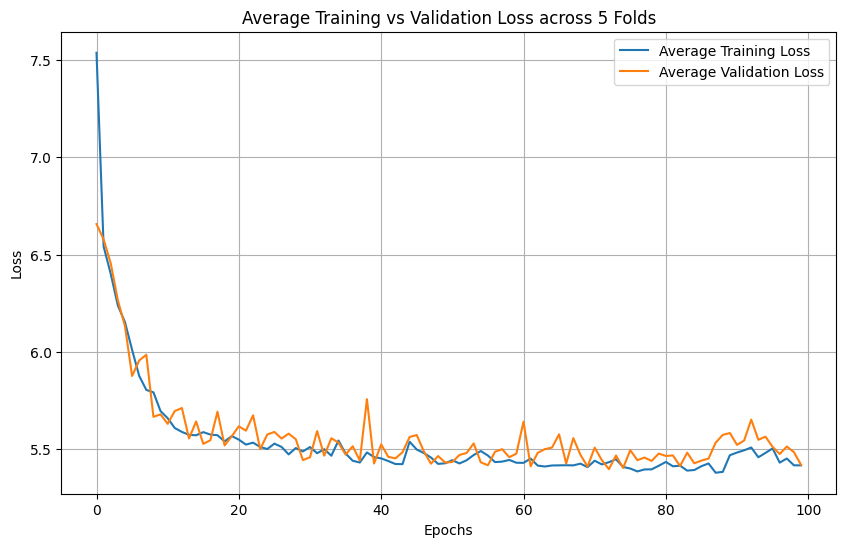

In [ ]:
mean_train_losses = np.mean(all_training_losses, axis=0)
mean_val_losses = np.mean(all_val_losses, axis=0)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(mean_train_losses, label='Average Training Loss')
plt.plot(mean_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Average Training vs Validation Loss across {k} Folds')
plt.legend()
plt.grid(True)
plt.show()

#### 7.3.5 Adding In Batch Normalization And Dropout


In [ ]:
class MLPRegressionModel3(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,dropout_rate=0.5):
        super(MLPRegressionModel3, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim//2)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim//2)
        self.fc3 = torch.nn.Linear(hidden_dim//2, hidden_dim//4)
        self.bn3 = torch.nn.BatchNorm1d(hidden_dim//4)
        self.fc4 = torch.nn.Linear(hidden_dim//4, hidden_dim//8)
        self.bn4 = torch.nn.BatchNorm1d(hidden_dim//8)
        self.fcLast = torch.nn.Linear(hidden_dim//8, output_dim)
        self.dropout = torch.nn.Dropout(p=dropout_rate)

    def forward(self, x):
        # Apply first fully connected layer, batch norm, ReLU, and dropout
        x = F.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)

        # Apply second fully connected layer, batch norm, ReLU, and dropout
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.dropout(x)

        # Apply third fully connected layer, batch norm, ReLU, and dropout
        x = F.relu(self.bn3(self.fc3(x)))
        x = self.dropout(x)

        # Apply fourth fully connected layer, batch norm, ReLU, and dropout
        x = F.relu(self.bn4(self.fc4(x)))
        x = self.dropout(x)

        # Apply the final fully connected layer
        x = self.fcLast(x)
        return x

In [ ]:
input_dim = train_dfx.shape[1]
print(input_dim)
hidden_dim = 128
output_dim = 1

model3 = MLPRegressionModel3(input_dim, hidden_dim, output_dim)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)

# Training loop
num_epochs =500  # Number of epochs for training

for epoch in range(num_epochs):
    model3.train()  # Set the model to training mode
    epoch_loss = 0  # Initialize loss for this epoch
    total_samples = 0
    for inputs, targets in FinalTrainComparisonloader:
        optimizer.zero_grad()  # Zero the gradients

        outputs = model3(inputs)  # Forward pass: compute predictions
        loss = criterion(outputs, targets.view(-1, 1).float())  # Compute loss

        loss.backward()  # Backward pass: compute gradients
        optimizer.step()  # Update model weights
        torch.nn.utils.clip_grad_norm_(model3.parameters(), max_norm=1.0)
        epoch_loss += loss.item()*inputs.size(0)  # Accumulate loss for this epoch
        total_samples += inputs.size(0)
    # Print average loss for the epoch
    avg_loss = epoch_loss/total_samples
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')

    model3.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    total_val_samples = 0


5
Epoch 1/500, Loss: 10.0543
Epoch 2/500, Loss: 7.3957
Epoch 3/500, Loss: 7.0941
Epoch 4/500, Loss: 6.9441
Epoch 5/500, Loss: 6.8835
Epoch 6/500, Loss: 6.8420
Epoch 7/500, Loss: 6.7127
Epoch 8/500, Loss: 6.5986
Epoch 9/500, Loss: 6.4254
Epoch 10/500, Loss: 6.3822
Epoch 11/500, Loss: 6.2575
Epoch 12/500, Loss: 6.1526
Epoch 13/500, Loss: 6.1252
Epoch 14/500, Loss: 6.0878
Epoch 15/500, Loss: 6.0188
Epoch 16/500, Loss: 5.9797
Epoch 17/500, Loss: 5.9307
Epoch 18/500, Loss: 5.9566
Epoch 19/500, Loss: 5.9188
Epoch 20/500, Loss: 5.8542
Epoch 21/500, Loss: 5.8440
Epoch 22/500, Loss: 5.8228
Epoch 23/500, Loss: 5.7885
Epoch 24/500, Loss: 5.7919
Epoch 25/500, Loss: 5.7580
Epoch 26/500, Loss: 5.7854
Epoch 27/500, Loss: 5.7702
Epoch 28/500, Loss: 5.7865
Epoch 29/500, Loss: 5.7368
Epoch 30/500, Loss: 5.7120
Epoch 31/500, Loss: 5.7818
Epoch 32/500, Loss: 5.7266
Epoch 33/500, Loss: 5.7423
Epoch 34/500, Loss: 5.7613
Epoch 35/500, Loss: 5.7641
Epoch 36/500, Loss: 5.7583
Epoch 37/500, Loss: 5.6974
Epoch 3

#### 7.3.6 Evaluation Of the Batch Normalization

After adding in Batch Normalization and Dropouts, the MLPRegression Deeper model has improved and is now the final model that is better than the initial MLP Model and the baseline Model.

The model did better than the baseline model and the final Graph Neural Network Model but worst than the initial simple MLP model as seen from the metrics such as the mean squared error,

From the model below, the results from the evaluation are as follows:

MAE:5.58

MSE:81.1937

RMSE:9.0108

MAPE:0.35


Initial MLP Model's Results:

MAE:5.66

MSE:96.91

RMSE:9.84

MAPE:0.3742

Baseline Model's Results:

MAE:6.40

MSE:84.45

RMSE:9.18

MAPE:0.4531

In [ ]:
model3.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate loss
total_loss = 0
n_batches = 0

all_actuals = []
all_predictions = []
all_differences = []


with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in testloader:
        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model3(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        # Compute the loss
        differences = targets.view(-1,1) - outputs

        all_actuals.extend(targets.detach().cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_differences.extend(differences.detach().cpu().numpy())
        # Accumulate loss
        total_loss += loss.item()
        n_batches += 1


all_actuals_tensor = torch.tensor(all_actuals, dtype=torch.float32)
all_predictions_tensor = torch.tensor(all_predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
mse = mse_loss(all_predictions_tensor, all_actuals_tensor.view(-1, 1))
print(f'Mean Squared Error (MSE) using nn.MSELoss: {mse.item():.4f}')

mae_loss = torch.nn.L1Loss()
mae=mae_loss(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Error (MAE) using nn.L1Loss: {mae.item():.4f}')


rmse = mean_squared_error(all_predictions_tensor,all_actuals_tensor.view(-1,1), squared=False)
print(f'Root Mean Squared Error (rmse): {rmse.item():.4f}')



mape = mean_absolute_percentage_error(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Percentage Error (MAE): {mape.item():.4f}')


Mean Squared Error (MSE) using nn.MSELoss: 81.1937
Mean Absolute Error (MAE) using nn.L1Loss: 5.5887
Root Mean Squared Error (rmse): 9.0108
Mean Absolute Percentage Error (MAE): 0.3500


####7.3.3 K-Fold Cross Validation And Evaluating the Graph
From the K-fold Cross validation, the training and valuation loss seems to be decreasing and remain close to each other and reaching a convergence point at around 40 epochs. The Training And Validation Loss are close to each other and shows that the model is alright.

In [ ]:
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)
fold_results = []
criterion = torch.nn.L1Loss()

all_training_losses=[]
all_val_losses =[]

##MLP 2


for fold, (train_index, val_index) in enumerate(kf.split(train_dfx)):
    print(f'Fold {fold + 1}/{k}')

    # Prepare train and validation data
    X_train, X_val = train_dfx[train_index], train_dfx[val_index]
    y_train, y_val = train_dfy[train_index], train_dfy[val_index]

    # Create datasets and dataloaders for each fold
    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Initialize the model, optimizer
    model3 = MLPRegressionModel3(input_dim=5, hidden_dim=128, output_dim=1)
    optimizer = torch.optim.Adam(model3.parameters(), lr=0.01)


    # initalize lists to store losses for this fold
    fold_train_losses = []
    fold_val_losses = []


    for epoch in range(100):  # Number of epochs, adjust as needed
        model3.train()
        running_loss = 0.0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model3(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_train_loss = running_loss / len(train_loader)
        fold_train_losses.append(avg_train_loss)

        model3.eval()
        val_loss = 0.0
        with torch.no_grad():
          for inputs, targets in val_loader:
            outputs = model3(inputs)
            loss = criterion(outputs.squeeze(), targets)
            val_loss += loss.item()

          avg_val_loss = val_loss / len(val_loader)
          fold_val_losses.append(avg_val_loss)
          fold_results.append(avg_val_loss)


        # Append the losses for this fold to the overall lists
        all_training_losses.append(fold_train_losses)
        all_val_losses.append(fold_val_losses)


# Average validation MAE across all folds
mean_val_loss = np.mean(fold_results)
print(f'Average Validation MAE across {k} folds: {mean_val_loss:.4f}')

Fold 1/5


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 5.6869


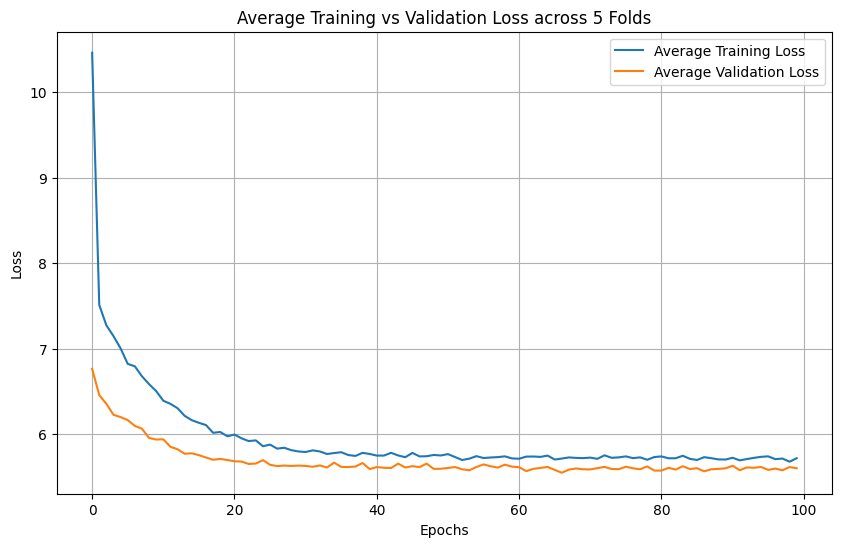

In [ ]:
mean_train_losses = np.mean(all_training_losses, axis=0)
mean_val_losses = np.mean(all_val_losses, axis=0)

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(mean_train_losses, label='Average Training Loss')
plt.plot(mean_val_losses, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'Average Training vs Validation Loss across {k} Folds')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Define hyperparameter grid
param_grid = {
    'lr':[0.001,0.005,0.01],
    'hidden_dim':[64,128],
    'dropout_rate':[0.3,0.5]

}

# Generate all combinations of hyperparameters
param_combinations = list(itertools.product(param_grid['lr'], param_grid['hidden_dim'], param_grid['dropout_rate']))

In [ ]:
def train_and_evaluate(input_dim, hidden_dim, output_dim, dropout_rate, lr, num_epochs=100, k=5):
    # Initialize KFold cross-validation
    kf = KFold(n_splits=k, shuffle=True, random_state=42)

    # Criterion and optimizer setup
    criterion = torch.nn.L1Loss()

    # Store losses for cross-validation
    all_training_losses = []
    all_val_losses = []
    fold_results = []

    for fold, (train_index, val_index) in enumerate(kf.split(train_dfx)):
        print(f'Fold {fold + 1}/{k}')

        # Split training data into fold-specific training and validation sets
        X_train, X_val = train_dfx[train_index], train_dfx[val_index]
        y_train, y_val = train_dfy[train_index], train_dfy[val_index]

        # Create TensorDatasets and DataLoaders for this fold
        train_dataset = TensorDataset(X_train, y_train)
        val_dataset = TensorDataset(X_val, y_val)

        train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

        # Initialize the model with the current hyperparameters
        model3 = MLPRegressionModel3(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate)
        optimizer = torch.optim.Adam(model3.parameters(), lr=lr)

        # Lists to store fold-specific training and validation losses
        fold_train_losses = []
        fold_val_losses = []

        for epoch in range(num_epochs):  # Train for a certain number of epochs
            model3.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = model3(inputs)
                loss = criterion(outputs.squeeze(), targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            avg_train_loss = running_loss / len(train_loader)
            fold_train_losses.append(avg_train_loss)

            # Validation step
            model3.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, targets in val_loader:
                    outputs = model3(inputs)
                    loss = criterion(outputs.squeeze(), targets)
                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader)
            fold_val_losses.append(avg_val_loss)
            fold_results.append(avg_val_loss)

        # Append fold losses to overall results
        all_training_losses.append(fold_train_losses)
        all_val_losses.append(fold_val_losses)

    # Average validation MAE across all folds
    mean_val_loss = np.mean(fold_results)
    print(f'Average Validation MAE across {k} folds: {mean_val_loss:.4f}')

    return mean_val_loss  # Return validation loss for hyperparameter tuning

In [ ]:
def hypertune(input_dim, output_dim, num_epochs=100, k=5):
    best_params = None
    best_val_loss = float('inf')

    # Iterate over all combinations of hyperparameters
    for lr in param_grid['lr']:
        for hidden_dim in param_grid['hidden_dim']:
            for dropout_rate in param_grid['dropout_rate']:
                print(f'Testing with lr={lr}, hidden_dim={hidden_dim}, dropout_rate={dropout_rate}')

                # Call the train_and_evaluate function with the current hyperparameters
                val_loss = train_and_evaluate(input_dim, hidden_dim, output_dim, dropout_rate, lr, num_epochs=num_epochs, k=k)

                # Track the best hyperparameters based on validation loss
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    best_params = (lr, hidden_dim, dropout_rate)

    print(f'Best Hyperparameters: lr={best_params[0]}, hidden_dim={best_params[1]}, dropout_rate={best_params[2]}')
    print(f'Best Validation Loss: {best_val_loss:.4f}')
    return best_params

In [ ]:
input_dim = 5
output_dim = 1

# Run the hypertune function to find the best hyperparameters
best_params = hypertune(input_dim, output_dim, num_epochs=100, k=5)

Testing with lr=0.001, hidden_dim=64, dropout_rate=0.3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 6.4489
Testing with lr=0.001, hidden_dim=64, dropout_rate=0.5
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 6.8920
Testing with lr=0.001, hidden_dim=128, dropout_rate=0.3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 6.0173
Testing with lr=0.001, hidden_dim=128, dropout_rate=0.5
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 6.3291
Testing with lr=0.005, hidden_dim=64, dropout_rate=0.3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 5.7747
Testing with lr=0.005, hidden_dim=64, dropout_rate=0.5
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MAE across 5 folds: 5.9738
Testing with lr=0.005, hidden_dim=128, dropout_rate=0.3
Fold 1/5
Fold 2/5
Fold 3/5
Fold 4/5
Fold 5/5
Average Validation MA

In [ ]:
model3.eval()  # Set the model to evaluation mode

# Initialize variables to accumulate loss
total_loss = 0
n_batches = 0

all_actuals = []
all_predictions = []
all_differences = []


with torch.no_grad():  # Disable gradient calculation
    for inputs, targets in testloader:
        # Forward pass: Compute predicted outputs by passing inputs to the model
        outputs = model3(inputs)
        loss = criterion(outputs, targets.view(-1, 1))
        # Compute the loss
        differences = targets.view(-1,1) - outputs

        all_actuals.extend(targets.detach().cpu().numpy())
        all_predictions.extend(outputs.detach().cpu().numpy())
        all_differences.extend(differences.detach().cpu().numpy())
        # Accumulate loss
        total_loss += loss.item()
        n_batches += 1


all_actuals_tensor = torch.tensor(all_actuals, dtype=torch.float32)
all_predictions_tensor = torch.tensor(all_predictions, dtype=torch.float32)

mse_loss = torch.nn.MSELoss()
mse = mse_loss(all_predictions_tensor, all_actuals_tensor.view(-1, 1))
print(f'Mean Squared Error (MSE) using nn.MSELoss: {mse.item():.4f}')

mae_loss = torch.nn.L1Loss()
mae=mae_loss(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Error (MAE) using nn.L1Loss: {mae.item():.4f}')


rmse = mean_squared_error(all_predictions_tensor,all_actuals_tensor.view(-1,1), squared=False)
print(f'Root Mean Squared Error (rmse): {rmse.item():.4f}')



mape = mean_absolute_percentage_error(all_predictions_tensor,all_actuals_tensor.view(-1,1))
print(f'Mean Absolute Percentage Error (MAE): {mape.item():.4f}')

Mean Squared Error (MSE) using nn.MSELoss: 79.6893
Mean Absolute Error (MAE) using nn.L1Loss: 5.5760
Root Mean Squared Error (rmse): 8.9269
Mean Absolute Percentage Error (MAE): 0.3458


###8 Conclusion
Comparing between the baseline model, The Graph Neural Network and the Multilayer Perceptron Network, The Multilayer Perceptron

The graph neural network has shown similar results to that of the baseline model even after hypertuning the parameters and the Multilayer Perceptron Network could predict the IPO_Prices much better than the two models stated above.

As seen from the evaluation metrics and the graphs, the Multilayer Perceptron has shown the best results which are displayed below:

----MLP----

Mean Squared Error: 79.6893

Mean Absolute Error: 5.5760

Root Mean Squared Error (RMSE): 8.9269

Mean Absolute Percentage Error (MAPE): 0.3458


---GNN---

Mean Squared Error: 99.0291

Mean Absolute Error: 6.3832

Root Mean Squared Error (RMSE): 9.9513

Mean Absolute Percentage Error (MAPE): 0.39

---Baseline---

Mean Squared Error: 84.45

Mean Absolute Error: 6.40

Root Mean Squared Error (RMSE): 9.18

Mean Absolute Percentage Error (MAPE): 0.4531

